In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set the display width to a large value
pd.set_option('display.expand_frame_repr', False)  
np.set_printoptions(threshold=np.inf)

sys.path.append('/efs/sameer.arora/scripts')

from util import PythonUtil

In [3]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import zscore

def get_zgt3_df(df, alpha):
    # Calculate absolute values and z-scores for the 'alpha' column
    abs_col = "abs." + alpha
    df[abs_col] = df[alpha].abs()
    df['z_score'] = (df[abs_col] - df[abs_col].mean()) / df[abs_col].std(ddof=1)
    
    # Filter the dataframe into two parts based on z-score values
    df_gt_3 = df[df['z_score'] > 3]
    
    return df_gt_3

def get_df_with_groups(df, alpha, numBuckets=5):

    abs_col = "abs." + alpha
    df[abs_col] = df[alpha].abs()
    col = abs_col

    # Calculate the quantile breaks
    breaks = df[col].quantile(np.linspace(0, 1, numBuckets + 1)).unique()
    
    # Check if there are enough unique breaks
    if len(breaks) < 3:
        warnings.warn(f"Insufficient unique breaks to create meaningful buckets for column: {col}")
        return None
    
    # Define labels for the buckets
    labels = breaks[1:].astype(str)
    
    # Create a copy of the DataFrame to avoid modifying the original
    df1 = df.copy()
    
    # Create the 'group' column by binning 'col' based on the breaks
    df1['group'] = pd.cut(df1[col], bins=breaks, labels=labels, include_lowest=True)
    
    # Remove rows where 'group' is NaN
    df1 = df1[df1['group'].notna()]
    
    return df1

def bucketcor(df, col, x, y, numBuckets=5):
    # Calculate the quantile breaks
    breaks = df[col].quantile(np.linspace(0, 1, numBuckets + 1)).unique()
    
    # Check if there are enough unique breaks
    if len(breaks) < 3:
        warnings.warn(f"Insufficient unique breaks to create meaningful buckets for column: {col}")
        return None
    
    # Define labels for the buckets
    labels = breaks[1:].astype(str)
    
    # Create a copy of the DataFrame to avoid modifying the original
    df1 = df.copy()
    
    # Create the 'group' column by binning 'col' based on the breaks
    df1['group'] = pd.cut(df1[col], bins=breaks, labels=labels, include_lowest=True)
    
    # Remove rows where 'group' is NaN
    df1 = df1[df1['group'].notna()]
    
    # Group by 'group' and calculate the correlation between 'x' and each column in 'y' within each group
    def compute_correlations(group):
        correlations = {}
        for y_col in y:
            corr = group[x].corr(group[y_col])
            correlations[y_col] = corr
        return pd.Series(correlations)
    
    df2 = df1.groupby('group').apply(compute_correlations).reset_index()
    
    return df2

def calculate_buckets(df, alpha, numBuckets=5):
    import warnings
    
    # Calculate absolute values and z-scores for the 'alpha' column
    abs_col = "abs." + alpha
    df[abs_col] = df[alpha].abs()
    df['z_score'] = (df[abs_col] - df[abs_col].mean()) / df[abs_col].std(ddof=1)
    
    # Define the list of return columns
    returns = [
        'return.1000', 'return.5000', 'return.10000', 'return.30000',
        'return.60000', 'return.300000', 'return.600000', 'return.900000',
        'return.1800000'
    ]
    
    # Select only the required columns
    df = df[[alpha, abs_col] + returns + ['z_score']]
    
    print("Total number of points:")
    print(len(df))
    
    # Calculate bucket correlations
    print(f"Calculating bucketcor for alpha: {alpha}")
    r = bucketcor(df, abs_col, alpha, returns, numBuckets)
    if r is not None:
        print(r)
    else:
        print(f"No valid result for alpha: {alpha}")
    
    # Filter the dataframe into two parts based on z-score values
    df_le_3 = df[df['z_score'] <= 3]
    df_gt_3 = df[df['z_score'] > 3]
    
    print("Total number of points with z-score <= 3:")
    print(len(df_le_3))
    print("Total number of points with z-score > 3:")
    print(len(df_gt_3))
    
    # Calculate bucket correlations for z-score <= 3
    print(f"Calculating bucketcor for z-score <= 3 for alpha: {alpha}")
    r1 = bucketcor(df_le_3, abs_col, alpha, returns, numBuckets)
    if r1 is not None:
        print(r1)
    else:
        print(f"No valid result for alpha: {alpha}")
    
    # Calculate bucket correlations for z-score > 3
    print(f"Calculating bucketcor for z-score > 3 for alpha: {alpha}")
    r2 = bucketcor(df_gt_3, abs_col, alpha, returns, numBuckets)
    if r2 is not None:
        print(r2)
    else:
        print(f"No valid result for alpha: {alpha}")

import pandas as pd

def getWorstDayTime(df, alpha, return_col):
    # Initialize variables
    rows_diff_than_alpha = 0
    worst_date_time = None
    worst_data = None
    worst_data_wrongs = None
    worst_data_rights = None

    # Ensure 'date_only' is of date type extracted from 'log_time'
    df['date_only'] = pd.to_datetime(df['log_time']).dt.date
    df['time_only'] = df['log_time'].dt.strftime('%H:%M:%S.%f')


    # Get unique days
    unique_days = df['date_only'].unique()

    # Iterate over unique days
    for day in unique_days:
        day_str = day.strftime('%Y-%m-%d')
        print('Day:', day_str)

        # Filter data for the specific day
        day_data = df[df['date_only'] == day]

        # Process each time for the day
        unique_times = day_data['time_only'].unique()

        for time in unique_times:
            time_str = str(time)
            print('Time:', time_str)

            # Filter data for the specific time
            time_data = day_data[day_data['time_only'] == time]

            # Calculate rows where alpha and return are mismatched
            current_rows_diff_than_alpha = ((time_data[alpha] * time_data[return_col]) < 0).sum()
            print('Rows diff than alpha:', current_rows_diff_than_alpha)

            # Update worst date and time if a higher mismatch count is found
            if current_rows_diff_than_alpha > rows_diff_than_alpha:
                rows_diff_than_alpha = current_rows_diff_than_alpha
                worst_date_time = f"{day_str} {time_str}"

                worst_data_rights = time_data[time_data[alpha] * time_data[return_col] >= 0]
                worst_data_wrongs = time_data[time_data[alpha] * time_data[return_col] < 0]
                worst_data = time_data

    print('Worst date time:', worst_date_time)
    print('Worst alpha-return mismatch count:', rows_diff_than_alpha)
    return {
        'worst_data': worst_data,
        'worst_data_wrongs': worst_data_wrongs,
        'worst_data_rights': worst_data_rights
    }

import pandas as pd

def getTimeAround(df_small, df_big, t):
    # Ensure 'log_time' is in datetime format and extract 'date_only'
    df_small['date_only'] = pd.to_datetime(df_small['log_time']).dt.date

    # Extract unique time(s) and date(s) from df_small
    c_time = df_small['time_only'].unique()
    c_date = df_small['date_only'].unique()

    # Check that there is only one unique time and date
    if len(c_time) != 1 or len(c_date) != 1:
        raise ValueError("df_small should contain data for only one unique time and one unique date.")

    time_str = str(c_time[0])
    date_str = str(c_date[0])
    print("Time:", time_str)

    # Create a datetime object combining date and time
    datetime_str = f"{date_str} {time_str}"
    datetime_obj = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S', utc=True)

    # Calculate t seconds before and after
    time_before = datetime_obj - pd.Timedelta(seconds=t)
    time_after = datetime_obj + pd.Timedelta(seconds=t)

    # Format times for printing
    time_before_str = time_before.strftime('%H:%M:%S.%f')
    time_after_str = time_after.strftime('%H:%M:%S.%f')

    print("Time before:", time_before_str)
    print("Time after:", time_after_str)

    # Prepare df_big by ensuring 'log_time' is in datetime format and extract 'date_only'
    if (df_big['log_time'].dtype != 'datetime64[ns]'):
        df_big['log_time'] = pd.to_datetime(df_big['log_time'])
    df_big['date_only'] = df_big['log_time'].dt.date
    df_big['time_only'] = df_big['log_time'].dt.strftime('%H:%M:%S.%f')

    dd = df_big[df_big['log_time'].dt.date == c_date[0]]
    print("Total number of points in df_big for the same date:", len(dd))

    # Filter df_big for times between time_before and time_after
    return dd[(dd['time_only'] >= time_before_str) & (dd['time_only'] <= time_after_str)]






In [4]:
df = PythonUtil.load_and_concat_to_feather(['/efs/sameer.arora/logs/paramSimIndexDEMA/config_0'], 'sample_')
df

CSV Files: ['/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-09-20.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-08-30.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-09-02.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-08-21.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-09-11.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-08-29.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-09-19.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-09-06.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-09-04.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024-08-23.log', '/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/sample_index_indicator.2024

KeyboardInterrupt: 

In [4]:
df.columns

Index(['log_time', 'log_level', 'contract', 'mid', 'weight', 'is_constituent',
       'vol_ratio', 'vol_ratio_index', 'vol_ratio_constituents', 'fi', 'fc',
       'r', 'r_ema', 'r_dema', 'ratio_diff', 'ratio_diff_dema', 'fi_ret',
       'fc_ret', 'fc_ret_2', 'balance', 'bid', 'bidsz', 'ask', 'asksz', 'ref',
       'bid.1000', 'bidsz.1000', 'ask.1000', 'asksz.1000', 'ref.1000',
       'return.1000', 'bid.5000', 'bidsz.5000', 'ask.5000', 'asksz.5000',
       'ref.5000', 'return.5000', 'bid.10000', 'bidsz.10000', 'ask.10000',
       'asksz.10000', 'ref.10000', 'return.10000', 'bid.30000', 'bidsz.30000',
       'ask.30000', 'asksz.30000', 'ref.30000', 'return.30000', 'bid.60000',
       'bidsz.60000', 'ask.60000', 'asksz.60000', 'ref.60000', 'return.60000',
       'bid.300000', 'bidsz.300000', 'ask.300000', 'asksz.300000',
       'ref.300000', 'return.300000', 'bid.600000', 'bidsz.600000',
       'ask.600000', 'asksz.600000', 'ref.600000', 'return.600000',
       'bid.900000', 'bidsz.90000

In [5]:
cols = ['log_time', 'log_level', 'contract', 'mid', 'weight', 'is_constituent',
       'vol_ratio', 'vol_ratio_index', 'vol_ratio_constituents', 'fi', 'fc',
       'r', 'r_ema', 'r_dema', 'ratio_diff', 'ratio_diff_dema', 'fi_ret',
       'fc_ret', 'fc_ret_2', 'balance', 
       'return.1000', 'return.5000', 'return.10000', 'return.30000', 'return.60000', 'return.300000', 'return.600000', 'return.900000', 'return.1800000']

df2 = df[cols]
df2

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,...,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000
0,2024-09-20 10:00:04.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,...,0.72,0.0033,-0.0346,-0.0609,-0.1478,-0.1274,-0.2894,-0.1883,-0.1399,0.6012
1,2024-09-20 10:00:04.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,...,0.72,0.0034,0.0021,0.0018,-0.0209,-0.0662,-0.2367,-0.2130,-0.2257,-0.0805
2,2024-09-20 10:00:04.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,...,0.72,-0.0282,-0.0065,0.0000,-0.1085,-0.1671,-0.4882,-0.2778,-0.2213,-0.6380
3,2024-09-20 10:00:04.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,...,0.72,0.0680,0.0227,0.0227,-0.0605,-0.3703,-0.0227,0.0378,-0.0605,0.1360
4,2024-09-20 10:00:04.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,...,0.72,0.0000,0.0000,0.0062,-0.0841,-0.1046,-0.3014,-0.2737,-0.1374,-0.0461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18248972,2024-09-10 15:57:59.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,...,-0.16,-0.0202,-0.0202,-0.0404,-0.0121,-0.0040,-0.1009,-0.1009,-0.1009,-0.1009
18248973,2024-09-10 15:57:59.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,...,-0.16,0.0000,0.0114,0.0057,0.0057,0.0057,0.0455,0.0455,0.0455,0.0455
18248974,2024-09-10 15:57:59.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,...,-0.16,0.0547,-0.0205,-0.1831,-0.0492,-0.0601,-0.3853,-0.3853,-0.3839,0.0410
18248975,2024-09-10 15:57:59.999651524,INFO,NSE_WIPRO,52640.0,0.318415,1,0.004624,0.002846,0.004458,2509940.0,...,-0.16,0.0000,0.0000,0.0000,-0.0190,-0.0571,-0.0856,-0.0856,-0.0856,-0.0856


In [7]:
del df

In [1]:
df2

NameError: name 'df2' is not defined

In [9]:
# save to feather
df2.to_feather('/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/df2.feather')

# Load feather

In [4]:
# load from feather
df = pd.read_feather('/efs/sameer.arora/logs/paramSimIndexDEMA/config_0/df2.feather')

In [5]:
df

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000
0,2024-09-20 10:00:04.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0033,-0.0346,-0.0609,-0.1478,-0.1274,-0.2894,-0.1883,-0.1399,0.6012
1,2024-09-20 10:00:04.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0034,0.0021,0.0018,-0.0209,-0.0662,-0.2367,-0.2130,-0.2257,-0.0805
2,2024-09-20 10:00:04.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,-0.0282,-0.0065,0.0000,-0.1085,-0.1671,-0.4882,-0.2778,-0.2213,-0.6380
3,2024-09-20 10:00:04.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0680,0.0227,0.0227,-0.0605,-0.3703,-0.0227,0.0378,-0.0605,0.1360
4,2024-09-20 10:00:04.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0000,0.0000,0.0062,-0.0841,-0.1046,-0.3014,-0.2737,-0.1374,-0.0461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18248972,2024-09-10 15:57:59.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,-0.0202,-0.0202,-0.0404,-0.0121,-0.0040,-0.1009,-0.1009,-0.1009,-0.1009
18248973,2024-09-10 15:57:59.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,0.0000,0.0114,0.0057,0.0057,0.0057,0.0455,0.0455,0.0455,0.0455
18248974,2024-09-10 15:57:59.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,0.0547,-0.0205,-0.1831,-0.0492,-0.0601,-0.3853,-0.3853,-0.3839,0.0410
18248975,2024-09-10 15:57:59.999651524,INFO,NSE_WIPRO,52640.0,0.318415,1,0.004624,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,0.0000,0.0000,0.0000,-0.0190,-0.0571,-0.0856,-0.0856,-0.0856,-0.0856


## ratio_diff

In [4]:
# y3 <- df[abs(df$fc_ret) <= abs(df$fi_ret) & (df$fi_ret * df$fc_ret > 0) & (df$fi_ret * df$ratio_diff > 0),]

expiry_dates = ['2024-08-22', '2024-08-29', '2024-09-05', '2024-09-12', '2024-09-19']
expiry_dates = [datetime.strptime(date, '%Y-%m-%d').date() for date in expiry_dates]
df['date_only'] = df['log_time'].dt.date

non_expiry = df[~df['date_only'].isin(expiry_dates)]
expiry = df[df['date_only'].isin(expiry_dates)]


In [8]:
print(np.sort(non_expiry['date_only'].unique()))

[datetime.date(2024, 8, 20) datetime.date(2024, 8, 21)
 datetime.date(2024, 8, 23) datetime.date(2024, 8, 26)
 datetime.date(2024, 8, 27) datetime.date(2024, 8, 28)
 datetime.date(2024, 8, 30) datetime.date(2024, 9, 2)
 datetime.date(2024, 9, 3) datetime.date(2024, 9, 4)
 datetime.date(2024, 9, 6) datetime.date(2024, 9, 9)
 datetime.date(2024, 9, 10) datetime.date(2024, 9, 11)
 datetime.date(2024, 9, 13) datetime.date(2024, 9, 16)
 datetime.date(2024, 9, 17) datetime.date(2024, 9, 18)
 datetime.date(2024, 9, 20)]


In [52]:
#y3$x <- y3$ratio_diff * abs(y3$fi_ret) * abs(y3$fc_ret) * abs(log(y3$vol_ratio_index) - log(y3$vol_ratio_constituents))
y3 = expiry[ (expiry['fc_ret'] * expiry['ratio_diff'] > 0)]

# y3 = y3[(y3['ratio_diff'].abs() >= 0.00001) ]
# y3 = y3[np.abs(np.log(y3['vol_ratio_index']) - np.log(y3['vol_ratio_constituents'])) >=  2.768890e-01]

# y3['std_fi_ret'] = zscore(y3['fi_ret'])
# y3['std_fc_ret'] = zscore(y3['fc_ret'])
# y3['std_ratio_diff'] = zscore(y3['ratio_diff'])

# y3 = y3[y3['x'].abs() >= 2.721019e-14]
y3['rv'] = y3['vol_ratio_index'] / y3['vol_ratio_constituents']
y3 = y3[y3['rv'] <= 1]


y3['x'] = (
    y3['ratio_diff'] *
    np.power(y3['fi_ret'],2) *
    np.power(y3['fc_ret'],2)
)

PythonUtil.calculate_buckets(y3, 'x')

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Total number of points:
970546
Calculating bucketcor for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0  2.5497079517853325e-26     0.013251     0.015306      0.020440      0.016584      0.003101       0.010575       0.004797       0.002084       -0.004732
1   4.074236272931081e-25     0.033459     0.026471      0.032071      0.011661      0.018861       0.021653       0.031117       0.018731       -0.016303
2  4.6421027013996644e-24     0.049252     0.042055      0.036781      0.019305     -0.000906       0.031993       0.033656       0.034888        0.009060
3   6.117726475654068e-23     0.063036     0.072099      0.056803      0.038876      0.035725       0.026266       0.029405       0.003654       -0.029001
4  3.1033919081827047e-18     0.060445     0.061889      0.046506      0.051083      0.036112       0.044113       0.060399       0.048623        0.061903
Tota

/efs/sameer.arora/scripts/util.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['log_time'] = a['log_time'].apply(PythonUtil.convert_log_time)


contract:NSE_ABB


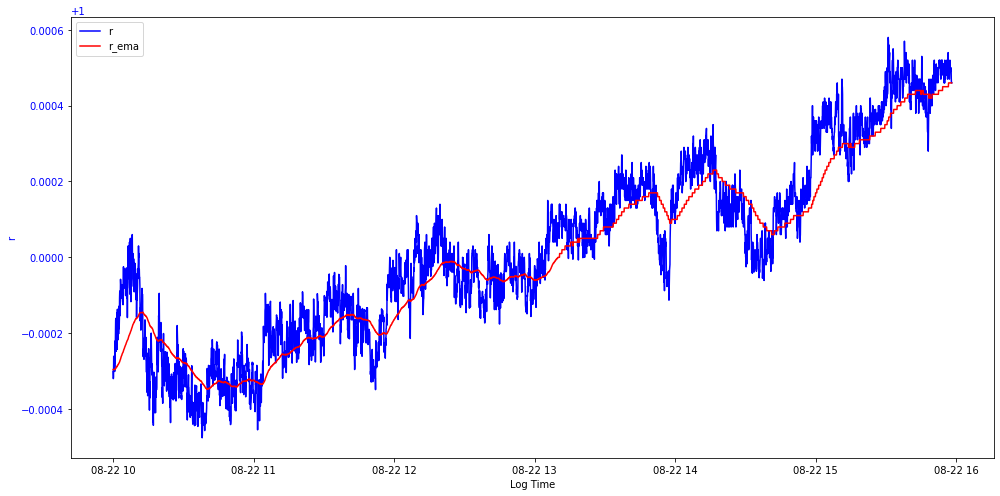

In [47]:
ff = df[df['log_time'].dt.date == datetime.strptime('2024-08-22', '%Y-%m-%d').date()]

PythonUtil.plot_compare_mids(ff, 'r', 'r_ema')

In [49]:
ff

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,date_only
10645291,2024-08-22 10:00:04.999781729,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.037392,0.008615,2485210.0,2485960.0,0.999699,0.999704,0.99975,-5.315610e-06,-0.000051,0.000173,0.000145,0.002933,0.8,0.0000,0.0035,-0.0016,0.0079,-0.0326,-0.1863,-0.1027,0.0117,-0.3464,2024-08-22
10645292,2024-08-22 10:00:04.999781729,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.037392,0.008615,2485210.0,2485960.0,0.999699,0.999704,0.99975,-5.315610e-06,-0.000051,0.000173,0.000145,0.002933,0.8,0.0232,0.0681,0.0681,0.1391,0.1389,0.2226,0.1611,0.5852,0.8403,2024-08-22
10645293,2024-08-22 10:00:04.999781729,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.037392,0.008615,2485210.0,2485960.0,0.999699,0.999704,0.99975,-5.315610e-06,-0.000051,0.000173,0.000145,0.002933,0.8,-0.0045,0.0471,0.0179,0.0471,0.0202,-0.0022,0.1996,0.0471,0.0920,2024-08-22
10645294,2024-08-22 10:00:04.999781729,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.037392,0.008615,2485210.0,2485960.0,0.999699,0.999704,0.99975,-5.315610e-06,-0.000051,0.000173,0.000145,0.002933,0.8,0.0000,0.0000,0.0236,0.0157,0.0314,-0.2122,-0.0864,-0.1729,-0.0157,2024-08-22
10645295,2024-08-22 10:00:04.999781729,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.037392,0.008615,2485210.0,2485960.0,0.999699,0.999704,0.99975,-5.315610e-06,-0.000051,0.000173,0.000145,0.002933,0.8,0.0140,0.0064,-0.0365,-0.0269,-0.0806,-0.0655,-0.2965,-0.1193,-0.2224,2024-08-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11405678,2024-08-22 15:57:59.999781729,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.003988,0.007490,2484160.0,2483020.0,1.000460,1.000460,1.00049,3.645770e-08,-0.000031,-0.000001,0.000006,-0.000453,0.0,0.0432,0.0432,0.0432,0.0216,0.0691,0.1210,0.1210,0.1210,0.1210,2024-08-22
11405679,2024-08-22 15:57:59.999781729,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.003988,0.007490,2484160.0,2483020.0,1.000460,1.000460,1.00049,3.645770e-08,-0.000031,-0.000001,0.000006,-0.000453,0.0,0.0000,0.0000,0.0000,0.0000,-0.0924,-0.1304,-0.1304,-0.0870,-0.1304,2024-08-22
11405680,2024-08-22 15:57:59.999781729,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.003988,0.007490,2484160.0,2483020.0,1.000460,1.000460,1.00049,3.645770e-08,-0.000031,-0.000001,0.000006,-0.000453,0.0,-0.0015,0.0074,-0.0371,-0.0030,-0.0074,-0.1706,-0.1706,-0.1691,-0.1691,2024-08-22
11405681,2024-08-22 15:57:59.999781729,INFO,NSE_WIPRO,52022.5,0.319495,1,0.008984,0.003988,0.007490,2484160.0,2483020.0,1.000460,1.000460,1.00049,3.645770e-08,-0.000031,-0.000001,0.000006,-0.000453,0.0,0.0048,0.0144,0.0241,0.0337,0.0626,0.0289,0.0289,0.0289,0.0289,2024-08-22


In [31]:
vv = y3['vol_ratio_index'] / y3['vol_ratio_constituents']
vv.describe()

count    1.329999e+06
mean     1.473996e+00
std      1.971731e+00
min      9.467998e-03
25%      4.895768e-01
50%      9.031764e-01
75%      1.746963e+00
max      5.225444e+01
dtype: float64

In [50]:
# decision tree
data = non_expiry.copy()



# Ensure all required columns are present
required_columns = ['fi','fc','fi_ret', 'fc_ret', 'ratio_diff', 'vol_ratio_index', 'vol_ratio_constituents', 'r','r_ema','r_dema']
assert all(column in data.columns for column in required_columns), "Some required columns are missing."

# Interaction terms
data['fi_ret_ratio_diff'] = data['fi_ret'] * data['ratio_diff']
data['fi_ret_fc_ret'] = data['fi_ret'] * data['fc_ret']
data['vol_ratio_difference'] = data['vol_ratio_index'] - data['vol_ratio_constituents']
data['volume_index_lead_flag'] = data['vol_ratio_index'] >= data['vol_ratio_constituents']
data['fi_ret_lead_flag'] = data['fi_ret'] >= data['fc_ret']
data['x'] = (
    data['ratio_diff'] *
    np.power(data['fi_ret'],2) *
    np.power(data['fc_ret'],2)
)

# Convert boolean to integer
data['volume_index_lead_flag'] = data['volume_index_lead_flag'].astype(int)
data['fi_ret_lead_flag'] = data['fi_ret_lead_flag'].astype(int)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text


features = required_columns + ['fi_ret_ratio_diff', 'fi_ret_fc_ret', 'vol_ratio_difference', 'volume_index_lead_flag', 'fi_ret_lead_flag', 'x']
top_features = ['r_ema', 'fc', 'r_dema', 'fi', 'r']
X = data[features]
y = data['return.600000']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Train the model
model = DecisionTreeRegressor(max_depth=5)  # Adjust max_depth as needed
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f'Model R^2 score: {score:.4f}')

Model R^2 score: 0.0173


In [51]:
# Get the text representation of the tree
tree_rules = export_text(model, feature_names=features)
print(tree_rules)

|--- fc <= 2577215.00
|   |--- r_dema <= 1.00
|   |   |--- r_ema <= 1.00
|   |   |   |--- r_dema <= 1.00
|   |   |   |   |--- r <= 1.00
|   |   |   |   |   |--- value: [0.03]
|   |   |   |   |--- r >  1.00
|   |   |   |   |   |--- value: [0.01]
|   |   |   |--- r_dema >  1.00
|   |   |   |   |--- r <= 1.00
|   |   |   |   |   |--- value: [-0.04]
|   |   |   |   |--- r >  1.00
|   |   |   |   |   |--- value: [-0.02]
|   |   |--- r_ema >  1.00
|   |   |   |--- r_ema <= 1.00
|   |   |   |   |--- fi <= 2519675.00
|   |   |   |   |   |--- value: [-0.37]
|   |   |   |   |--- fi >  2519675.00
|   |   |   |   |   |--- value: [-0.29]
|   |   |   |--- r_ema >  1.00
|   |   |   |   |--- r_ema <= 1.00
|   |   |   |   |   |--- value: [-0.21]
|   |   |   |   |--- r_ema >  1.00
|   |   |   |   |   |--- value: [-0.10]
|   |--- r_dema >  1.00
|   |   |--- fc <= 2498905.00
|   |   |   |--- r_dema <= 1.00
|   |   |   |   |--- r_ema <= 1.00
|   |   |   |   |   |--- value: [-0.12]
|   |   |   |   |--- r_em

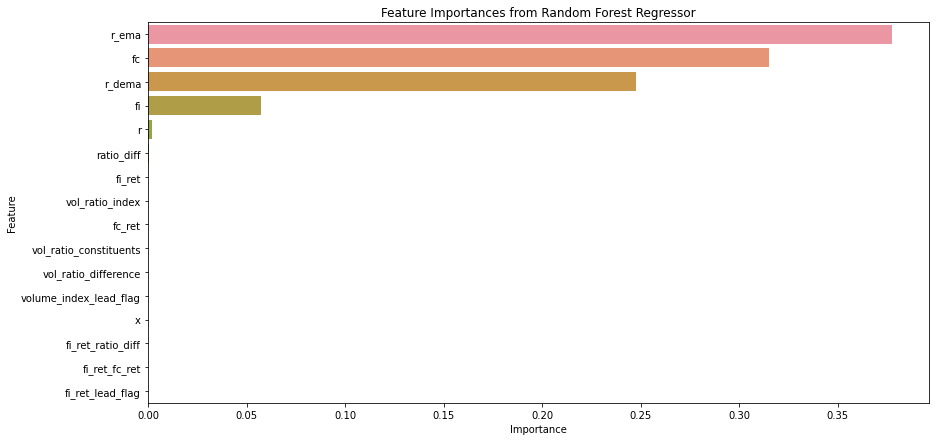

In [7]:
import pandas as pd
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(14, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest Regressor')
plt.show()

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Random Forest Regressor Performance on Test Set:')
print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


# Training performance
y_train_pred = rf_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f'R² Score on Training Set: {r2_train:.4f}')

Random Forest Regressor Performance on Test Set:
R² Score: 0.0168
Mean Absolute Error (MAE): 0.1400
Mean Squared Error (MSE): 0.0410
Root Mean Squared Error (RMSE): 0.2024
R² Score on Training Set: 0.0170


In [55]:
d1 = y3[(y3['x'].abs() >= 9.87472205352453e-12) & (y3['x'].abs() <= 1.2580633382261342e-11)]
d1['group'] = "d1"
d2 = y3[(y3['x'].abs() >= 1.2580633382261342e-11) & (y3['x'].abs() <= 1.660617614799985e-11 )]
d2['group'] = "d2"
combined = pd.concat([d1, d2])
w = getWorstDayTime(d, 'x', 'return.10000')['worst_data']

Day: 2024-09-20
Time: 14:20:14.999593
Rows diff than alpha: 118
Time: 15:27:04.999593
Rows diff than alpha: 63
Time: 15:30:24.999593
Rows diff than alpha: 21
Time: 15:30:29.999593
Rows diff than alpha: 47
Day: 2024-09-06
Time: 10:36:29.999155
Rows diff than alpha: 117
Day: 2024-08-28
Time: 10:16:09.999320
Rows diff than alpha: 41
Day: 2024-08-20
Time: 10:02:59.999430
Rows diff than alpha: 73
Time: 10:04:09.999430
Rows diff than alpha: 59
Worst date time: 2024-09-20 14:20:14.999593
Worst alpha-return mismatch count: 118


/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
ww = getTimeAround(w, non_expiry, 30)

Time: 14:20:14.999593
Time before: 14:19:44.999593
Time after: 14:20:44.999593


/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total number of points in df_big for the same date: 760392


contract:NSE_ABB


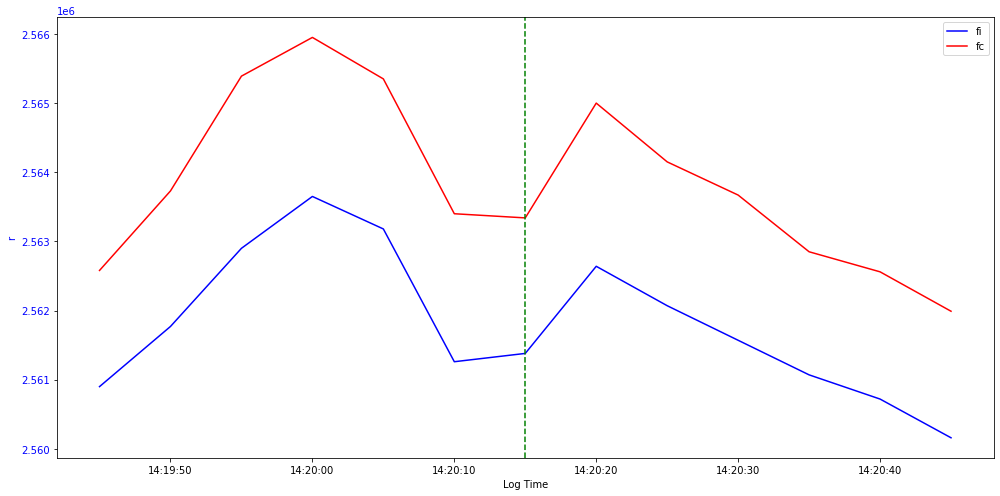

In [63]:
PythonUtil.plot_compare_mids(ww, 'fi', 'fc', selected_time='2024-09-20 14:20:14.999593')

contract:NSE_ABB


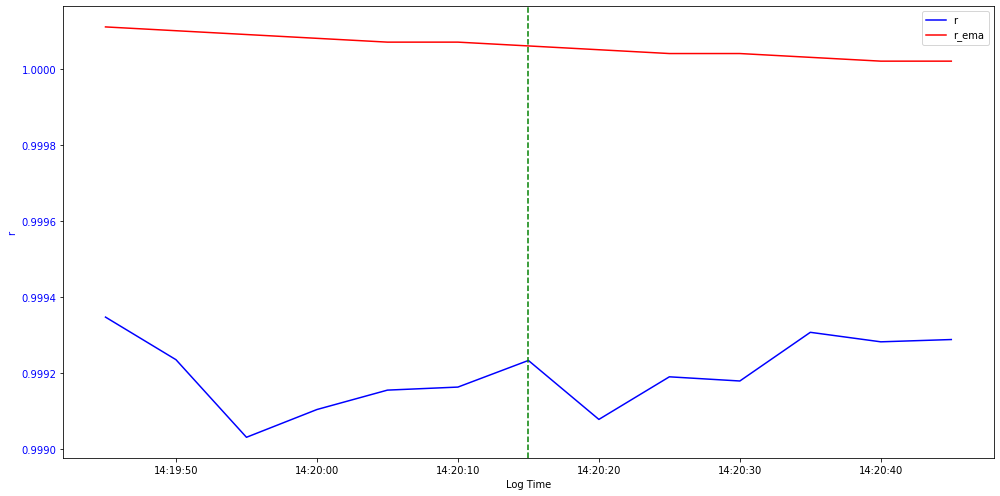

In [64]:
PythonUtil.plot_compare_mids(ww, 'r', 'r_ema', selected_time='2024-09-20 14:20:14.999593')

In [66]:
d1 = y3[(y3['x'].abs() >= 9.87472205352453e-12) & (y3['x'].abs() <= 1.2580633382261342e-11)]
d1['group'] = "d1"
d2 = y3[(y3['x'].abs() >= 1.2580633382261342e-11) & (y3['x'].abs() <= 1.660617614799985e-11 )]
d2['group'] = "d2"
combined = pd.concat([d1, d2])
combined

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,x,abs.x,z_score,abs.norm_diff,abs.abs.norm_diff,time_only,group
552594,2024-09-20 14:20:14.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0161,0.0171,0.0154,-0.0477,0.0049,0.1689,-0.1893,-0.1413,0.1614,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1
552595,2024-09-20 14:20:14.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0122,0.0150,0.0169,0.0339,0.0771,0.2839,0.1881,0.2269,0.3889,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1
552596,2024-09-20 14:20:14.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0417,0.0614,0.0351,-0.0767,-0.0197,0.0877,-0.3639,-0.2499,0.1074,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1
552597,2024-09-20 14:20:14.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0000,0.0000,-0.0153,-0.0306,-0.0459,-0.0153,-0.1912,-0.4512,-0.1759,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1
552598,2024-09-20 14:20:14.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0000,0.0000,0.0000,-0.0473,-0.0185,-0.0031,-0.1471,-0.1039,0.5093,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16755977,2024-08-20 10:13:04.999430255,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.005241,0.011021,2468600.0,2469250.0,0.999737,0.996755,1.00488,0.002982,-0.005140,0.000064,0.000070,0.002188,0.40,0.0000,0.0089,-0.0133,0.0178,0.0489,-0.0889,-0.1867,-0.2045,-0.1956,-1.903843,-1.871966,-0.031877,1.017029,2024-08-20,1.317166e-11,1.317166e-11,4.608614,0.031877,0.031877,10:13:04.999430,d2
16755978,2024-08-20 10:13:04.999430255,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.005241,0.011021,2468600.0,2469250.0,0.999737,0.996755,1.00488,0.002982,-0.005140,0.000064,0.000070,0.002188,0.40,0.0226,0.0226,0.0226,0.0679,0.0453,0.1075,0.0283,0.0339,0.0566,-1.903843,-1.871966,-0.031877,1.017029,2024-08-20,1.317166e-11,1.317166e-11,4.608614,0.031877,0.031877,10:13:04.999430,d2
16755979,2024-08-20 10:13:04.999430255,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.005241,0.011021,2468600.0,2469250.0,0.999737,0.996755,1.00488,0.002982,-0.005140,0.000064,0.000070,0.002188,0.40,0.0109,0.0016,-0.0467,-0.0903,-0.1136,-0.1961,0.1058,0.0016,-0.4109,-1.903843,-1.871966,-0.031877,1.017029,2024-08-20,1.317166e-11,1.317166e-11,4.608614,0.031877,0.031877,10:13:04.999430,d2
16755980,2024-08-20 10:13:04.999430255,INFO,NSE_WIPRO,52647.5,0.319495,1,0.007702,0.005241,0.011021,2468600.0,2469250.0,0.999737,0.996755,1.00488,0.002982,-0.005140,0.000064,0.000070,0.002188,0.40,-0.0143,0.0190,0.0190,0.0000,-0.0523,0.1237,-0.1665,-0.0333,0.0666,-1.903843,-1.871966,-0.031877,1.017029,2024-08-20,1.317166e-11,1.317166e-11,4.60

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

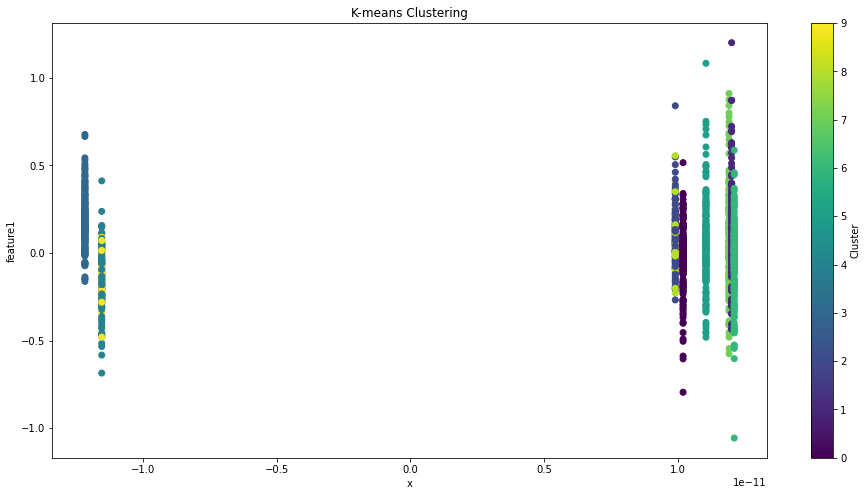

In [107]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming 'combined' is your DataFrame and 'group' is one of the columns.

# 1. Prepare the Data
# Exclude the 'group' column from clustering features
# X = d1[['is_constituent', 'vol_ratio', 'vol_ratio_index', 'vol_ratio_constituents', 'fi', 'fc', 'r', 'r_ema', 'r_dema', 'ratio_diff', 'ratio_diff_dema', 'fi_ret', 'fc_ret', 'fc_ret_2','x']]
d1['abs.fi_ret'] = d1['fi_ret'].abs()
d1['abs.fc_ret'] = d1['fc_ret'].abs()

features = ['is_constituent', 'vol_ratio', 'vol_ratio_index', 'vol_ratio_constituents', 'fi', 'fc', 'r', 'r_ema', 'r_dema', 'ratio_diff', 'ratio_diff_dema', 'fi_ret', 'fc_ret', 'fc_ret_2','x','abs.fi_ret','abs.fc_ret']  # replace with actual column names you want to use for clustering
X = d1[features]

# Step 2: Apply K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust 'n_clusters' based on your needs
d1['cluster'] = kmeans.fit_predict(X)

# Step 3: Visualize the clustering result (if you have 2 or 3 features)
plt.figure(figsize=(16, 8))
plt.scatter(d1['x'], d1['return.300000'], c=d1['cluster'], cmap='viridis')
plt.xlabel('x')
plt.ylabel('feature1')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()


In [88]:
d1['abs.x'] = d1['x'].abs()
c0 = d1[d1['cluster'] == 0]
c1 = d1[d1['cluster'] == 1]

PythonUtil.bucketcor(d1, 'abs.x', 'x', ['return.1000', 'return.5000','return.10000','return.30000', 'return.60000', 'return.300000', 'return.600000', 'return.900000', 'return.1800000'])


/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,group,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000
0,1.0177990872711203e-11,-1.746358e-01,-2.345818e-01,-1.366281e-01,-4.412352e-01,-5.020000e-01,-3.139407e-01,-1.674347e-01,-2.512870e-01,-1.271578e-01
1,1.1526788551656249e-11,-3.764254e-02,2.726624e-01,9.142208e-02,-1.070773e-01,1.569639e-01,4.374129e-01,2.827791e-01,4.063357e-01,4.047876e-01
2,1.1894454085083487e-11,-1.082747e-16,1.304868e-17,8.774634e-17,-1.977173e-17,8.058976e-18,4.084993e-17,-8.315986e-19,3.690668e-17,-6.224829e-18
3,1.2087880234695271e-11,1.806144e-02,-3.450577e-01,-4.275597e-01,2.479047e-01,-1.687470e-01,-2.798605e-01,-1.582241e-01,-9.028111e-02,-2.179726e-01
4,1.2154787837575961e-11,-3.293585e-17,-3.223239e-17,7.015929e-17,-9.238034e-17,2.384931e-17,-2.545870e-16,-6.946738e-17,-1.185419e-17,7.053534e-17


In [94]:
d1

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,x,abs.x,z_score,abs.norm_diff,abs.abs.norm_diff,time_only,group,cluster,abs.fi_ret,abs.fc_ret
552594,2024-09-20 14:20:14.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0161,0.0171,0.0154,-0.0477,0.0049,0.1689,-0.1893,-0.1413,0.1614,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1,1,0.000091,0.000162
552595,2024-09-20 14:20:14.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0122,0.0150,0.0169,0.0339,0.0771,0.2839,0.1881,0.2269,0.3889,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1,1,0.000091,0.000162
552596,2024-09-20 14:20:14.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0417,0.0614,0.0351,-0.0767,-0.0197,0.0877,-0.3639,-0.2499,0.1074,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1,1,0.000091,0.000162
552597,2024-09-20 14:20:14.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0000,0.0000,-0.0153,-0.0306,-0.0459,-0.0153,-0.1912,-0.4512,-0.1759,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1,1,0.000091,0.000162
552598,2024-09-20 14:20:14.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.006701,0.008153,2561380.0,2563340.0,0.999233,1.000060,1.00005,-0.000827,-0.000814,-0.000091,-0.000162,-0.003385,-0.72,0.0000,0.0000,0.0000,-0.0473,-0.0185,-0.0031,-0.1471,-0.1039,0.5093,1.791832,1.832250,-0.040417,0.977941,2024-09-20,-1.215479e-11,1.215479e-11,4.243540,0.040417,0.040417,14:20:14.999593,d1,1,0.000091,0.000162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16737038,2024-08-20 10:04:09.999430255,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.005331,0.007513,2464860.0,2465780.0,0.999624,0.992579,1.00606,0.007045,-0.006440,0.000102,0.000014,0.000276,-0.04,0.0000,0.0267,0.0579,0.0534,-0.0134,0.0267,0.1291,-0.0445,-0.0178,-2.052817,-2.008576,-0.044241,1.022026,2024-08-20,1.017799e-11,1.017799e-11,3.533835,0.044241,0.044241,10:04:09.999430,d1,0,0.000102,0.000014
16737039,2024-08-20 10:04:09.999430255,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.005331,0.007513,2464860.0,2465780.0,0.999624,0.992579,1.00606,0.007045,-0.006440,0.000102,0.000014,0.000276,-0.04,-0.0113,-0.0056,-0.0056,-0.1072,-0.1749,0.0000,-0.2877,-0.3046,-0.4287,-2.052817,-2.008576,-0.044241,1.022026,2024-08-20,1.017799e-11,1.017799e-11,3.533835,0.044241,0.044241,10:04:09.999430,d1,0,0.000102,0.000014
16737040,2024-08-20 10:04:09.999430255,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.005331,0.007513,2464860.0,2465780.0,0.999624,0.992579,1.00606,0.007045,-0.006440,0.000102,0.000014,0.000276,-0.04,0.0000,0.0124,0.0124,0.0216,0.0216,-0.6043,-0.9087,-0.9242,-1.1962,-2.052817,-2.008576,-0.044241,1.022026,2024-08-20,1.017799e-11,1.017799e-11,3.533835,0.044241,0.044241,10:04:09.999430,d1,0,0.000102,0.000014
16737041,2024-08-20 10:04:09.999430255,INFO,NSE_WIPRO,52727.5,0.319495,1,0.002543,0.005331,0.007513,2464860.0,2465780.0,0.999624,0.992

In [60]:
y3['vol_ratio_constituents'].describe()

count    1.142004e+06
mean     6.082137e-03
std      4.865256e-03
min      9.275520e-04
25%      3.622390e-03
50%      5.036605e-03
75%      7.106400e-03
max      1.896240e-01
Name: vol_ratio_constituents, dtype: float64

In [40]:
vv = y3['ratio_diff'].abs()
vv.quantile(np.arange(0, 1.1, 0.33))

0.00    1.763890e-10
0.33    3.979690e-05
0.66    9.013430e-05
0.99    5.088090e-04
Name: ratio_diff, dtype: float64

In [129]:
# d == 9.146212639903474e-19 
d = y3[(y3['x'].abs() > 5.151458265990122e-19) & (y3['x'].abs() <= 9.146212639903474e-19 )]
w = getWorstDayTime(d, 'x', 'return.1800000')['worst_data']

ww = getTimeAround(w, non_expiry, 1800)

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Day: 2024-09-20
Time: 15:20:54.999593
Rows diff than alpha: 77
Day: 2024-09-06
Time: 10:07:19.999155
Rows diff than alpha: 172
Time: 10:15:09.999155
Rows diff than alpha: 4
Day: 2024-08-28
Time: 10:05:24.999320
Rows diff than alpha: 43
Day: 2024-09-18
Time: 14:10:49.999799
Rows diff than alpha: 143
Worst date time: 2024-09-06 10:07:19.999155
Worst alpha-return mismatch count: 172
Time: 10:07:19.999155
Time before: 09:37:19.999155
Time after: 10:37:19.999155


/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total number of points in df_big for the same date: 760392


In [130]:
ww

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,r2_ema,r2_diff,date_only,time_only
5322547,2024-09-06 10:00:04.999155969,INFO,NSE_ABB,0.0,0.000000,-1,0.00000,0.005051,0.003308,2519200.0,2521860.0,0.998947,0.999212,0.998765,-0.000265,0.000183,0.000056,0.000035,-0.000564,0.04,0.0000,0.0333,0.0609,0.0432,0.0652,0.2691,0.0807,-0.0464,-0.3940,0.111690,0.199230,-0.087539,0.560611,1.04305,-0.482439,2024-09-06,10:00:04.999155
5322548,2024-09-06 10:00:04.999155969,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.00000,0.005051,0.003308,2519200.0,2521860.0,0.998947,0.999212,0.998765,-0.000265,0.000183,0.000056,0.000035,-0.000564,0.04,0.0052,0.0175,0.0175,0.0201,0.0196,0.2511,0.1664,0.2334,0.1500,0.111690,0.199230,-0.087539,0.560611,1.04305,-0.482439,2024-09-06,10:00:04.999155
5322549,2024-09-06 10:00:04.999155969,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.00000,0.005051,0.003308,2519200.0,2521860.0,0.998947,0.999212,0.998765,-0.000265,0.000183,0.000056,0.000035,-0.000564,0.04,0.0045,0.0090,0.0627,-0.0022,0.0694,-0.1008,-0.0806,-0.2844,-0.9292,0.111690,0.199230,-0.087539,0.560611,1.04305,-0.482439,2024-09-06,10:00:04.999155
5322550,2024-09-06 10:00:04.999155969,INFO,NSE_ABFRL,0.0,0.000000,-1,0.00000,0.005051,0.003308,2519200.0,2521860.0,0.998947,0.999212,0.998765,-0.000265,0.000183,0.000056,0.000035,-0.000564,0.04,0.0000,0.0080,0.0080,-0.1595,-0.2074,-0.1276,-0.3031,-0.5903,-0.8216,0.111690,0.199230,-0.087539,0.560611,1.04305,-0.482439,2024-09-06,10:00:04.999155
5322551,2024-09-06 10:00:04.999155969,INFO,NSE_ACC,0.0,0.000000,-1,0.00000,0.005051,0.003308,2519200.0,2521860.0,0.998947,0.999212,0.998765,-0.000265,0.000183,0.000056,0.000035,-0.000564,0.04,0.0042,0.0218,0.0707,0.0312,0.0177,0.4501,0.3524,0.0187,-0.6476,0.111690,0.199230,-0.087539,0.560611,1.04305,-0.482439,2024-09-06,10:00:04.999155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5401838,2024-09-06 10:37:19.999155969,INFO,NSE_UPL,0.0,0.000000,-1,0.00000,0.004363,0.002808,2498960.0,2501320.0,0.999054,0.999087,0.999079,-0.000033,-0.000025,0.000051,0.000036,0.001196,0.16,0.0000,0.0041,0.0450,0.0041,-0.1760,0.2087,0.1432,0.2578,0.0573,-0.694523,-0.609407,-0.085116,1.139671,1.16667,-0.027000,2024-09-06,10:37:19.999155
5401839,2024-09-06 10:37:19.999155969,INFO,NSE_VEDL,0.0,0.000000,-1,0.00000,0.004363,0.002808,2498960.0,2501320.0,0.999054,0.999087,0.999079,-0.000033,-0.000025,0.000051,0.000036,0.001196,0.16,-0.0163,-0.0109,-0.0163,-0.0488,-0.2116,-0.0217,-0.5101,-0.4938,-0.5752,-0.694523,-0.609407,-0.085116,1.139671,1.16667,-0.027000,2024-09-06,10:37:19.999155
5401840,2024-09-06 10:37:19.999155969,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.00000,0.004363,0.002808,2498960.0,2501320.0,0.999054,0.999087,0.999079,-0.000033,-0.000025,0.000051,0.000036,0.001196,0.16,-0.0014,0.0028,0.0042,0.0212,-0.1386,0.0255,0.0552,0.1089,-0.0792,-0.694523,-0.609407,-0.085116,1.139671,1.16667,-0.027000,2024-09-06,10:37:19.999155
5401841,2024-09-06 10:37:19.999155969,INFO,NSE_WIPRO,52612.5,0.318415,1,0.05555,0.004363,0.002808,2498960.0,2501320.0,0.999054,0.999087,0.999079,-0.000033,-0.000025,0.000051,0.000036,0.001196,0.16,-0.0334,0.0095,0.0477,0.0000,-0.0572,-0.1336,-0.2958,-0.2385,-0.4770,-0.694523,-0.609407,-0.085116,1.139671,1.16667,-0.027000,2024-09-06,10:37:19.999155


contract:NSE_ABB


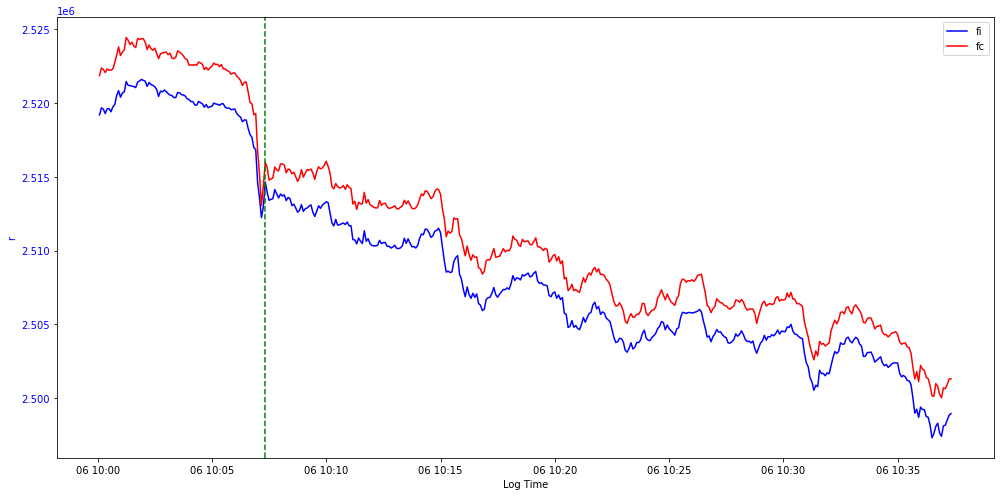

In [143]:
PythonUtil.plot_compare_mids(ww, 'fi', 'fc', selected_time='2024-09-06 10:07:19.999155')

contract:NSE_ABB


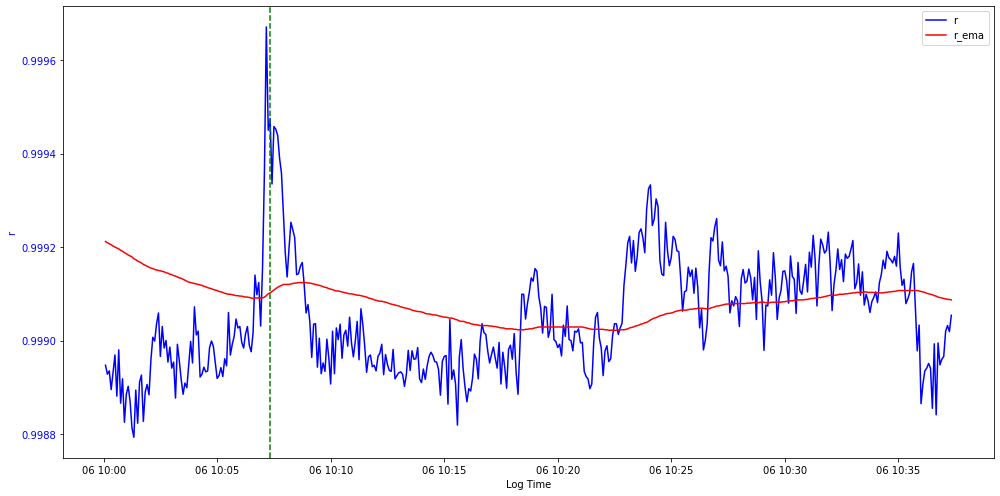

In [144]:



def plot_compare_mids(a, mid1, mid2, selected_contract=None, selected_time=None):
    # Apply the conversion to the log_time column
    a['log_time'] = a['log_time'].apply(PythonUtil.convert_log_time)

    # Pick the first contract if not specified
    if selected_contract is None:
        selected_contract = a['contract'].iloc[0]

    print("Selected Contract:", selected_contract)

    # Filter the data for the selected contract
    a = a[a['contract'] == selected_contract]

    # Create a figure and primary axis
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot mid1 on the primary y-axis
    ax1.plot(a['log_time'], a[mid1], color='blue', label=mid1)
    ax1.set_xlabel('Log Time')
    ax1.set_ylabel(mid1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Create a secondary y-axis for mid2
    ax2 = ax1.twinx()
    ax2.plot(a['log_time'], a[mid2], color='red', label=mid2)
    ax2.set_ylabel(mid2, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    # Add a vertical line if `selected_time` is provided
    if selected_time is not None:
        t = PythonUtil.convert_log_time(selected_time)
        ax1.axvline(x=t, color='green', linestyle='--')

    fig.tight_layout()
    plt.title(f'Comparison of {mid1} and {mid2} for Contract: {selected_contract}')
    plt.grid(True)
    plt.show()

PythonUtil.plot_compare_mids(ww, 'r', 'r_ema', selected_time='2024-09-06 10:07:19.999155')

contract:NSE_ABB


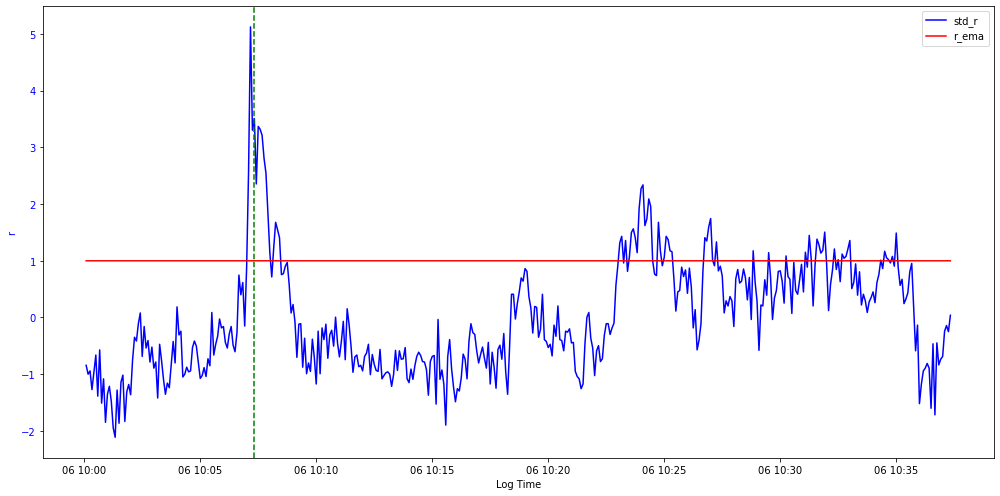

In [145]:
ww['std_r'] = zscore(ww['r'])
PythonUtil.plot_compare_mids(ww, 'std_r', 'r_ema', selected_time='2024-09-06 10:07:19.999155')

NSE_ABB
                             log_time log_level contract  mid  weight  is_constituent  vol_ratio  vol_ratio_index  vol_ratio_constituents         fi         fc         r     r_ema    r_dema  ratio_diff  ratio_diff_dema    fi_ret    fc_ret  fc_ret_2  balance  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000  fi_over_std  fc_over_std  norm_diff        r2    r2_ema   r2_diff   date_only        time_only             x
5322547 2024-09-06 10:00:04.999155969      INFO  NSE_ABB  0.0     0.0              -1        0.0         0.005051                0.003308  2519200.0  2521860.0  0.998947  0.999212  0.998765   -0.000265         0.000183  0.000056  0.000035 -0.000564     0.04       0.0000       0.0333        0.0609        0.0432        0.0652         0.2691         0.0807        -0.0464         -0.3940     0.111690     0.199230  -0.087539  0.560611  1.043050 -0.482439  2024-09-06  10:00:04.999155 -4.338785e-2

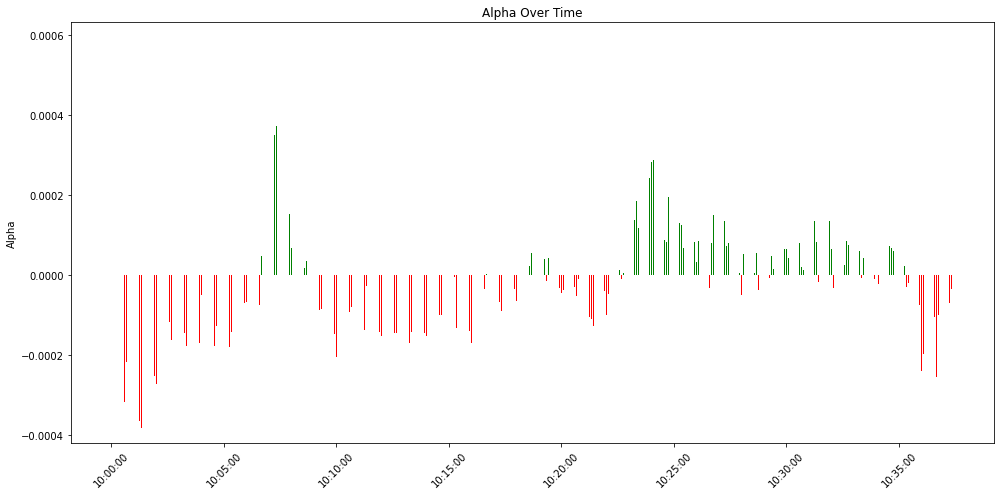

In [133]:
def plot_only_alpha(a, alpha_name, selected_contract=None):
    # Apply the conversion to the log_time column
    a['log_time'] = a['log_time'].apply(PythonUtil.convert_log_time)

    # Pick the first name in contracts if none is selected
    if selected_contract is None:
        selected_contract = a['contract'].iloc[0]

    # Filter the data for the selected contract
    print(selected_contract)
    a = a[a['contract'] == selected_contract]
    print(a)

    # Check for negative alpha values
    print('Min alpha value:', a[alpha_name].min())

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot the alpha values as a bar chart
    colors = ['green' if alpha >= 0 else 'red' for alpha in a[alpha_name]]
    ax1.bar(a['log_time'], a[alpha_name], color=colors, label='Alpha', width=0.00001)

    # Set y-axis limits to include negative values
    ymin = a[alpha_name].min() * 1.1  # Slightly extend the min for better visibility
    ymax = a[alpha_name].max() * 1.1  # Slightly extend the max
    ax1.set_ylim([ymin, ymax])

    # Label for the y-axis
    ax1.set_ylabel('Alpha')

    # Formatting the x-axis for better time visibility
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))
    plt.xticks(rotation=45)

    # Add a title and make the layout tighter
    plt.title('Alpha Over Time')
    fig.tight_layout()

    # Show the plot
    plt.show()


ww['x'] = (
    ww['ratio_diff'] *
    np.power(ww['fi_ret'], 2) *
    np.power(ww['fc_ret'],2) *
    np.abs(np.log(ww['vol_ratio_index']) - np.log(ww['vol_ratio_constituents']))
)


plot_only_alpha(ww, 'ratio_diff')

NSE_ABB
                             log_time log_level contract  mid  weight  is_constituent  vol_ratio  vol_ratio_index  vol_ratio_constituents         fi         fc         r     r_ema    r_dema  ratio_diff  ratio_diff_dema    fi_ret    fc_ret  fc_ret_2  balance  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000  fi_over_std  fc_over_std  norm_diff        r2    r2_ema   r2_diff   date_only        time_only             x
5322547 2024-09-06 10:00:04.999155969      INFO  NSE_ABB  0.0     0.0              -1        0.0         0.005051                0.003308  2519200.0  2521860.0  0.998947  0.999212  0.998765   -0.000265         0.000183  0.000056  0.000035 -0.000564     0.04       0.0000       0.0333        0.0609        0.0432        0.0652         0.2691         0.0807        -0.0464         -0.3940     0.111690     0.199230  -0.087539  0.560611  1.043050 -0.482439  2024-09-06  10:00:04.999155 -4.338785e-2

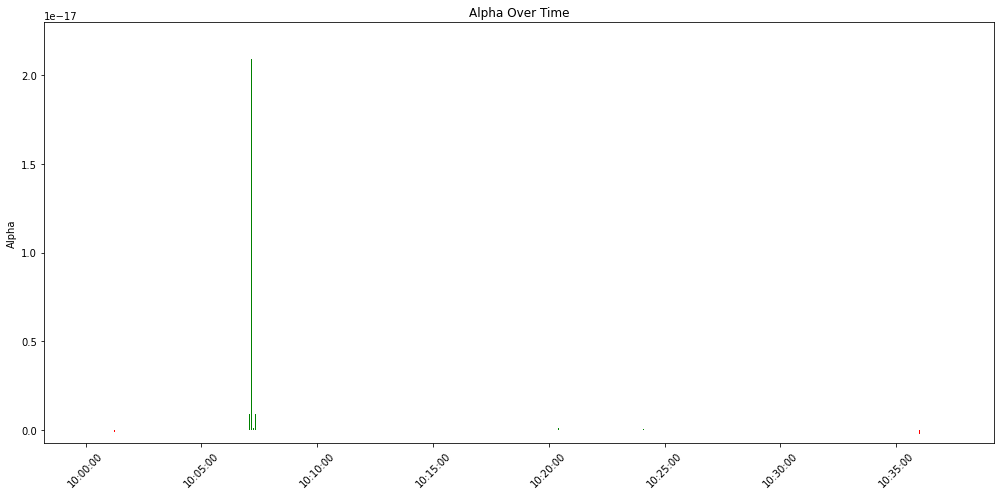

In [134]:
plot_only_alpha(ww, 'x')

NSE_ABB
                             log_time log_level contract  mid  weight  is_constituent  vol_ratio  vol_ratio_index  vol_ratio_constituents         fi         fc         r     r_ema    r_dema  ratio_diff  ratio_diff_dema    fi_ret    fc_ret  fc_ret_2  balance  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000  fi_over_std  fc_over_std  norm_diff        r2    r2_ema   r2_diff   date_only        time_only             x  std_fi_ret  std_fc_ret  std_ratio_diff         y
5322547 2024-09-06 10:00:04.999155969      INFO  NSE_ABB  0.0     0.0              -1        0.0         0.005051                0.003308  2519200.0  2521860.0  0.998947  0.999212  0.998765   -0.000265         0.000183  0.000056  0.000035 -0.000564     0.04       0.0000       0.0333        0.0609        0.0432        0.0652         0.2691         0.0807        -0.0464         -0.3940     0.111690     0.199230  -0.087539  0.560611  1.043050 -

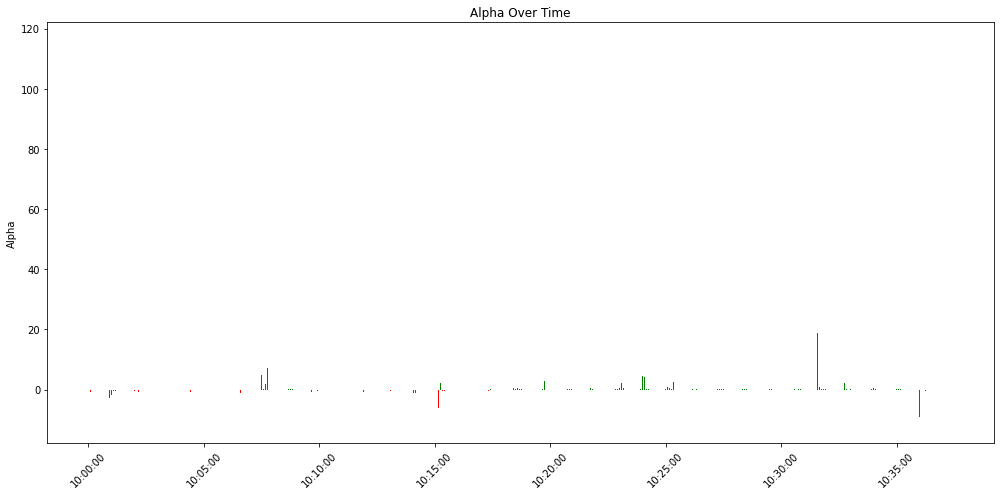

In [135]:
ww['std_fi_ret'] = zscore(ww['fi_ret'])
ww['std_fc_ret'] = zscore(ww['fc_ret'])
ww['std_ratio_diff'] = zscore(ww['ratio_diff'])

ww['y'] = (
    ww['std_ratio_diff'] *
    ww['std_fi_ret'].abs() *
    ww['std_fc_ret'].abs()
)

plot_only_alpha(ww, 'y')


In [136]:
ww['abs.x'] = ww['x'].abs()
ww['abs.y'] = ww['y'].abs()
ww['abs.ratio_diff'] = ww['ratio_diff'].abs()

returns = ['return.300000', 'return.600000', 'return.900000', 'return.1800000']
print(PythonUtil.bucketcor(ww, 'abs.x', 'x', returns))
print(PythonUtil.bucketcor(ww, 'abs.y', 'y', returns))
print(PythonUtil.bucketcor(ww, 'abs.ratio_diff', 'ratio_diff', returns))


                    group  return.300000  return.600000  return.900000  return.1800000
0  1.1841158293270143e-24      -0.076133      -0.054385      -0.008431        0.148459
1   2.151676493717684e-23      -0.001930      -0.069041      -0.015196        0.184613
2  1.3954079964982813e-22      -0.061776      -0.048229       0.000776        0.175564
3   1.838210529566806e-21       0.034662      -0.029601      -0.086111        0.220495
4  2.0879419367032615e-17       0.057098       0.007583       0.026025       -0.064623
                  group  return.300000  return.600000  return.900000  return.1800000
0  0.014760060053171471      -0.198577      -0.022413       0.007786        0.176870
1  0.056394626609300134      -0.070237      -0.029116      -0.011727        0.281821
2    0.1919491086937155      -0.059913      -0.007096      -0.001863        0.249224
3    0.6780528982123896      -0.047614      -0.095180      -0.117806        0.257982
4    110.98132580447019       0.046849      -0.016509

In [54]:
# Calculating bucketcor for z-score > 3 for alpha: x
#                     group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
# 0   3.673041300598109e-19     0.421922     0.520450      0.425273      0.238234      0.036296       0.089188       0.188991       0.195103        0.174771
# 1   5.151458265990122e-19     0.269734     0.118361      0.062284      0.008581      0.237767      -0.321466      -0.325788      -0.124723        0.145406
# 2   9.146212639903474e-19     0.312594     0.315109      0.113115      0.087992      0.245020      -0.168303      -0.153630      -0.122865        0.039278
# 3  1.7691283347435247e-18     0.255384     0.122087      0.164970      0.309765      0.314362       0.185290       0.209141       0.151569        0.227234
# 4   1.241546377448827e-17     0.215252    -0.065986     -0.259079     -0.121569      0.322442       0.388178       0.112594       0.462153        0.248122

vv = np.abs(np.log(y3['vol_ratio_index']) - np.log(y3['vol_ratio_constituents']))
vv.describe()

count    3.318396e+06
mean     7.197785e-01
std      5.650022e-01
min      8.229247e-05
25%      2.768890e-01
50%      5.967908e-01
75%      1.029852e+00
max      4.350391e+00
dtype: float64

In [57]:
y3['ratio_diff'].abs().describe()

count    3.318396e+06
mean     9.883463e-05
std      2.752443e-04
min      1.354070e-08
25%      3.084205e-05
50%      6.424625e-05
75%      1.135697e-04
max      9.638110e-03
Name: ratio_diff, dtype: float64

In [51]:
y3gt3 = get_zgt3_df(y3, 'x')
y3gt3 = get_df_with_groups(y3gt3, 'x')

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [25]:
y3gt3

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,x,abs.x,z_score,group
216648,2024-09-20 11:42:04.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.091815,0.026990,2567310.0,2567460.0,0.999942,0.999775,0.999793,0.000167,0.000149,0.000303,0.000288,0.005209,0.92,-0.0043,-0.0286,-0.0177,-0.0118,0.0144,0.1461,0.1612,0.1681,0.1225,1.784619e-11,1.784619e-11,4.396968,2.1920375127612853e-11
216649,2024-09-20 11:42:04.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.091815,0.026990,2567310.0,2567460.0,0.999942,0.999775,0.999793,0.000167,0.000149,0.000303,0.000288,0.005209,0.92,0.0001,-0.0022,-0.0117,-0.0161,-0.0086,-0.0894,-0.1753,-0.2536,-0.2675,1.784619e-11,1.784619e-11,4.396968,2.1920375127612853e-11
216650,2024-09-20 11:42:04.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.091815,0.026990,2567310.0,2567460.0,0.999942,0.999775,0.999793,0.000167,0.000149,0.000303,0.000288,0.005209,0.92,-0.0220,-0.0264,0.0022,-0.0285,0.0066,-0.2855,0.1603,0.2196,0.3140,1.784619e-11,1.784619e-11,4.396968,2.1920375127612853e-11
216651,2024-09-20 11:42:04.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.091815,0.026990,2567310.0,2567460.0,0.999942,0.999775,0.999793,0.000167,0.000149,0.000303,0.000288,0.005209,0.92,0.0000,0.0075,0.0075,0.0151,0.0000,-0.1358,0.0377,0.0151,0.0830,1.784619e-11,1.784619e-11,4.396968,2.1920375127612853e-11
216652,2024-09-20 11:42:04.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.091815,0.026990,2567310.0,2567460.0,0.999942,0.999775,0.999793,0.000167,0.000149,0.000303,0.000288,0.005209,0.92,0.0134,0.0227,0.0155,-0.0217,0.0712,0.2703,0.1496,0.3095,0.7809,1.784619e-11,1.784619e-11,4.396968,2.1920375127612853e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803109,2024-09-10 12:28:04.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.338955,0.045058,2505880.0,2506900.0,0.999591,0.999498,0.999550,0.000093,0.000041,0.000345,0.000299,0.005538,0.96,0.0122,-0.0041,0.0041,0.0244,0.0163,-0.0122,-0.0853,0.0244,-0.1016,1.930250e-11,1.930250e-11,4.760417,2.1920375127612853e-11
17803110,2024-09-10 12:28:04.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.338955,0.045058,2505880.0,2506900.0,0.999591,0.999498,0.999550,0.000093,0.000041,0.000345,0.000299,0.005538,0.96,0.0169,0.0226,0.0000,-0.0169,-0.0169,-0.0226,0.0000,-0.0734,-0.1751,1.930250e-11,1.930250e-11,4.760417,2.1920375127612853e-11
17803111,2024-09-10 12:28:04.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.338955,0.045058,2505880.0,2506900.0,0.999591,0.999498,0.999550,0.000093,0.000041,0.000345,0.000299,0.005538,0.96,0.0000,0.0097,0.0097,0.0235,0.0083,-0.0262,0.0166,0.0221,-0.0152,1.930250e-11,1.930250e-11,4.760417,2.1920375127612853e-11
17803112,2024-09-10 12:28:04.999651524,INFO,NSE_WIPRO,52002.5,0.318415,1,0.042869,0.338955,0.045058,2505880.0,2506900.0,0.999591,0.999498,0.999550,0.000093,0.000041,0.000345,0.000299,0.005538,0.96,0.0048,0.0048,0.0048,0.0338,0.0145,0.0772,0.1834,0.1545,0.3331,1.930250e-11,1.930250e-11,4.760417,2.1920375127612853e-11


In [29]:
# unique groups
y3gt3['group'].unique()

['2.1920375127612853e-11', '7.353577457654901e-11', '1.589990573481406e-11', '3.8385729596738623e-10', '3.225493630037576e-11']
Categories (5, object): ['1.589990573481406e-11' < '2.1920375127612853e-11' < '3.225493630037576e-11' < '7.353577457654901e-11' < '3.8385729596738623e-10']

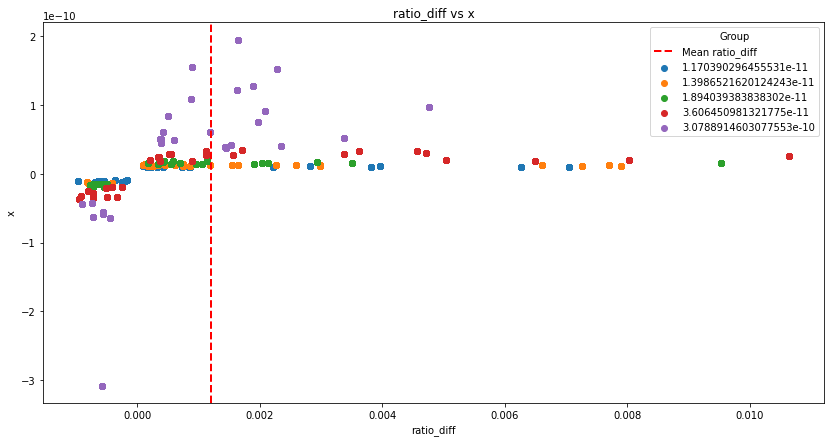

In [58]:
# plot ratio_diff vs x
fig, ax = plt.subplots(figsize=(14, 7))

mean_ratio_diff = y3gt3['ratio_diff'].mean()

# Group the data by 'group'
groups = y3gt3.groupby('group')

# Iterate over each group and plot
for name, group in groups:
    ax.scatter(group['ratio_diff'], group['x'], label=name)

ax.axvline(mean_ratio_diff, color='red', linestyle='--', linewidth=2, label='Mean ratio_diff')

# Set labels and title
ax.set_xlabel('ratio_diff')
ax.set_ylabel('x')
ax.set_title('ratio_diff vs x')

# Show legend
ax.legend(title='Group')

# Display the plot
plt.show()


Calculating bucketcor for z-score > 3 for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0   1.589990573481406e-11     0.315361     0.399867      0.393808      0.244227      0.310037       0.311438       0.293505       0.296024        0.395116
1  2.1920375127612853e-11     0.094104     0.094778      0.058890      0.224266      0.254504       0.058426       0.084858       0.128454        0.134727
2   3.225493630037576e-11     0.262015     0.189101      0.039683     -0.073281      0.065961       0.114626       0.090432      -0.016153       -0.054456
3   7.353577457654901e-11     0.280205     0.156828      0.126334      0.253681      0.203754       0.217681       0.114096       0.203325        0.277991
4  3.8385729596738623e-10     0.312292     0.461250      0.375113      0.364243      0.239289       0.412189       0.290996       0.220183        0.338786

In [33]:
# range of ratio_diff
print(y3gt3['ratio_diff'].min())
print(y3gt3['ratio_diff'].max())

# mean of ratio_diff
print(y3gt3['ratio_diff'].mean())

-0.000945823
0.00503187
0.0006466206630434783


## Exp vs non exp

df[df['contract'] == 'NSE_RELIANCE']

## Std norm_diff | r2_diff

## r2_diff

In [33]:
df['fi_over_std'] = zscore(df['fi'])
df['fc_over_std'] = zscore(df['fc'])
df['norm_diff'] = df['fi_over_std'] - df['fc_over_std']
df['norm_diff_2'] = df['fi_over_std'].abs() - df['fc_over_std'].abs()
df['r2'] = df['fi_over_std'] / df['fc_over_std']


contract:NSE_ABB


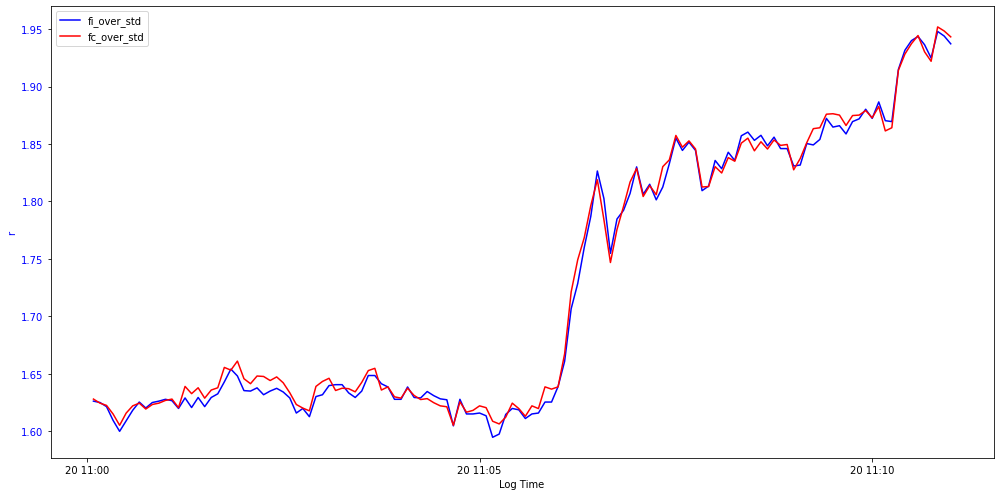

In [56]:
d = non_expiry[non_expiry['date_only'] == non_expiry['date_only'].iloc[0]]

# 30 mins from 11 to 11:30
d = d[(d['log_time'].dt.hour == 11) & (d['log_time'].dt.minute >= 0) & (d['log_time'].dt.minute <= 10)]

PythonUtil.plot_compare_mids(d, 'fi_over_std', 'fc_over_std')

NSE_ABB


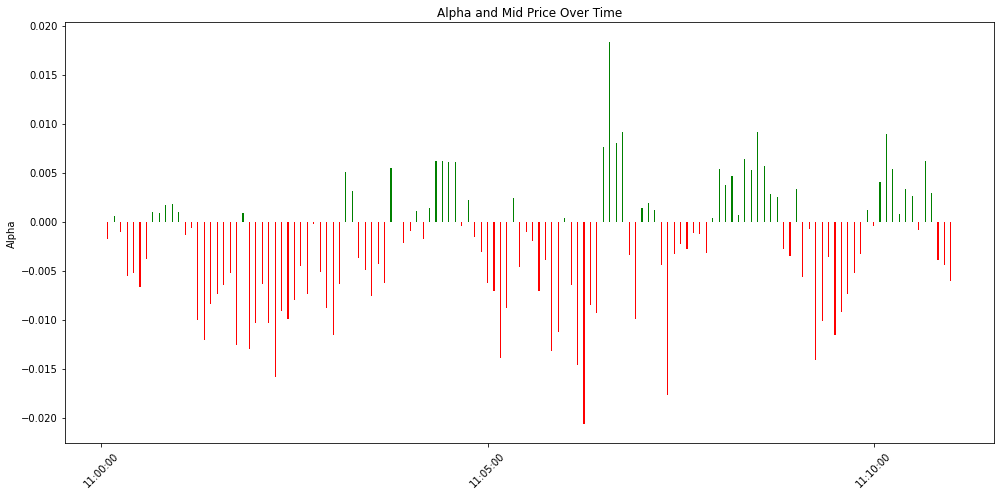

In [57]:
PythonUtil.plot_only_alpha(d, 'norm_diff')

In [14]:
unique_df = df.drop_duplicates(subset=['log_time'])[['log_time', 'r2']]
unique_df['r2_ema'] = unique_df['r2'].ewm(span=100, adjust=False).mean()
unique_df['r2_diff'] = unique_df['r2'] - unique_df['r2_ema']
unique_df

,log_time,r2,r2_ema,r2_diff
0,2024-09-20 10:00:04.999593398,1.028606,1.028606,0.000000
177,2024-09-20 10:00:09.999593398,1.029434,1.028622,0.000812
354,2024-09-20 10:00:14.999593398,1.029663,1.028643,0.001020
531,2024-09-20 10:00:19.999593398,1.028935,1.028649,0.000286
708,2024-09-20 10:00:24.999593398,1.031861,1.028712,0.003149
...,...,...,...,...
18248092,2024-09-10 15:57:39.999651524,0.973455,0.984156,-0.010701
18248269,2024-09-10 15:57:44.999651524,0.962171,0.983721,-0.021550
18248446,2024-09-10 15:57:49.999651524,0.964662,0.983343,-0.018682
18248623,2024-09-10 15:57:54.999651524,0.960683,0.982895,-0.022212


In [16]:
df = df.merge(unique_df[['log_time', 'r2_ema', 'r2_diff']], on='log_time', how='left')

In [17]:
df

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,date_only,fi_over_std,fc_over_std,norm_diff,r2,r2_ema,r2_diff
0,2024-09-20 10:00:04.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0033,-0.0346,-0.0609,-0.1478,-0.1274,-0.2894,-0.1883,-0.1399,0.6012,2024-09-20,1.371996,1.333840,0.038156,1.028606,1.028606,0.000000
1,2024-09-20 10:00:04.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0034,0.0021,0.0018,-0.0209,-0.0662,-0.2367,-0.2130,-0.2257,-0.0805,2024-09-20,1.371996,1.333840,0.038156,1.028606,1.028606,0.000000
2,2024-09-20 10:00:04.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,-0.0282,-0.0065,0.0000,-0.1085,-0.1671,-0.4882,-0.2778,-0.2213,-0.6380,2024-09-20,1.371996,1.333840,0.038156,1.028606,1.028606,0.000000
3,2024-09-20 10:00:04.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0680,0.0227,0.0227,-0.0605,-0.3703,-0.0227,0.0378,-0.0605,0.1360,2024-09-20,1.371996,1.333840,0.038156,1.028606,1.028606,0.000000
4,2024-09-20 10:00:04.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.002315,0.003596,2550840.0,2550680.0,1.000060,1.000190,1.000030,-0.000128,0.000033,0.000118,0.000149,0.003268,0.72,0.0000,0.0000,0.0062,-0.0841,-0.1046,-0.3014,-0.2737,-0.1374,-0.0461,2024-09-20,1.371996,1.333840,0.038156,1.028606,1.028606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18248972,2024-09-10 15:57:59.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,-0.0202,-0.0202,-0.0404,-0.0121,-0.0040,-0.1009,-0.1009,-0.1009,-0.1009,2024-09-10,-0.257160,-0.267685,0.010525,0.960683,0.982455,-0.021772
18248973,2024-09-10 15:57:59.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,0.0000,0.0114,0.0057,0.0057,0.0057,0.0455,0.0455,0.0455,0.0455,2024-09-10,-0.257160,-0.267685,0.010525,0.960683,0.982455,-0.021772
18248974,2024-09-10 15:57:59.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,0.0547,-0.0205,-0.1831,-0.0492,-0.0601,-0.3853,-0.3853,-0.3839,0.0410,2024-09-10,-0.257160,-0.267685,0.010525,0.960683,0.982455,-0.021772
18248975,2024-09-10 15:57:59.999651524,INFO,NSE_WIPRO,52640.0,0.318415,1,0.004624,0.002846,0.004458,2509940.0,2510000.0,0.999974,0.999877,0.999959,0.000098,0.000016,-0.000009,-0.000019,-0.000340,-0.16,0.0000,0.0000,0.0000,-0.0190,-0.0571,-0.0856,-0.0856,-0.0856,-0.0856,2024-09-10,-0.257160,-0.267685,0.010525,0.960683,0.982455,-0.021772


In [10]:
df['r2_diff'].describe()   

count    1.824898e+07
mean    -2.217197e-05
std      1.598738e+00
min     -2.633431e+01
25%     -5.866383e-03
50%     -6.011223e-05
75%      5.836710e-03
max      3.527499e+02
Name: r2_diff, dtype: float64

In [21]:
# get row with max r2_diff
df[df['r2_diff'] == df['r2_diff'].max()]

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,r2_ema,r2_diff
18028789,2024-09-10 14:14:24.999651524,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,0.0000,0.0000,-0.0017,0.0040,-0.0800,-0.0083,-0.0605,0.0678,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028790,2024-09-10 14:14:24.999651524,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,-0.0075,-0.0072,-0.0075,0.0127,-0.0347,-0.0582,-0.0706,-0.0756,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028791,2024-09-10 14:14:24.999651524,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,0.0000,-0.0023,-0.0068,-0.0273,-0.0251,-0.2233,-0.3623,-0.1777,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028792,2024-09-10 14:14:24.999651524,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0237,0.0552,0.0237,-0.0158,0.1263,0.3788,0.3867,0.3631,0.3710,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028793,2024-09-10 14:14:24.999651524,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,-0.0082,-0.0082,-0.0123,-0.0123,-0.0123,-0.0347,-0.1369,-0.1900,0.0245,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18028961,2024-09-10 14:14:24.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,0.0000,0.0000,0.0000,0.0284,0.0324,-0.0649,-0.0568,-0.0284,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028962,2024-09-10 14:14:24.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,0.0000,0.0113,0.0564,0.0507,-0.1183,-0.1578,-0.2592,-0.2705,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028963,2024-09-10 14:14:24.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,0.0014,0.0151,0.0289,-0.0069,0.0812,0.1088,-0.0647,0.1886,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865
18028964,2024-09-10 14:14:24.999651524,INFO,NSE_WIPRO,52877.5,0.318415,1,0.011974,0.005235,0.004909,2516610.0,2516800.0,0.999924,0.999866,0.999914,0.000058,0.00001,0.000025,0.000003,0.000084,0.04,0.0000,0.0332,0.0379,0.0664,0.0996,-0.1517,-0.2323,-0.3367,-0.2086,0.008524,0.000023,0.0085,366.483935,13.73407,352.749865


In [34]:
expiry_dates = ['2024-08-22', '2024-08-29', '2024-09-05', '2024-09-12', '2024-09-19']
expiry_dates = [datetime.strptime(date, '%Y-%m-%d').date() for date in expiry_dates]
df['date_only'] = df['log_time'].dt.date

non_expiry = df[~df['date_only'].isin(expiry_dates)]
expiry = df[df['date_only'].isin(expiry_dates)]

In [12]:
print(len(non_expiry['date_only'].unique()))
print(len(expiry['date_only'].unique()))

19
5


In [33]:
y3 = non_expiry[(non_expiry['fi_ret'] * non_expiry['fc_ret'] > 0) & (non_expiry['fi_ret'] * non_expiry['r2_diff'] > 0) & (non_expiry['fi_ret'].abs() >= non_expiry['fc_ret'].abs())]

y3 = y3[y3['r2_diff'].abs() > 0.003]

y3['x'] = (
    y3['r2_diff'] *
    np.sqrt(
    y3['fi_ret'].abs() *
    y3['fc_ret'].abs() 
    )
)

# y3['x'] = (
#     y3['r2_diff'] *
#     np.power(y3['fi_ret'],2) *
#     np.power(y3['fc_ret'],2)
# )

PythonUtil.calculate_buckets(y3, 'x')

Total number of points:
2049658
Calculating bucketcor for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0   5.756197545452534e-08     0.017769     0.025263      0.025899      0.015806      0.014400      -0.013125      -0.005020      -0.005906       -0.004576
1  1.2141004768778285e-07     0.037486     0.041782      0.041529      0.029231      0.019693      -0.001842       0.004635       0.005832        0.002504
2   2.318573965369984e-07     0.053289     0.061106      0.056106      0.028771      0.028621       0.013400       0.011247       0.014393        0.003559
3   5.079902188970481e-07     0.076088     0.082416      0.074843      0.048922      0.034449       0.008068       0.013870       0.021215        0.006371
4   0.0030413824908942693     0.007892     0.009141      0.006377      0.004756      0.007447       0.004123       0.001436      -0.000812       -0.002753
Tot

In [34]:
# find outliers un y3 of r2_diff
y3['r2_diff'].describe()
# y3['r2_diff'].abs().quantile(np.arange(0, 1.1, 0.1))

count    2.049658e+06
mean     1.374385e-02
std      3.295359e+00
min     -1.045577e+01
25%     -8.705762e-03
50%     -3.156437e-03
75%      8.323735e-03
max      3.527499e+02
Name: r2_diff, dtype: float64

---

## norm_diff

In [31]:
# quantile of vol_ratio_index
print(non_expiry['vol_ratio_index'].quantile([0.25, 0.5, 0.75]))
print(non_expiry['vol_ratio_constituents'].quantile(np.arange(0, 1.1, 0.1)))
print((non_expiry['vol_ratio_index'] / non_expiry['vol_ratio_constituents']).quantile(np.arange(0, 1.1, 0.1)))

0.25    0.002192
0.50    0.003859
0.75    0.007041
Name: vol_ratio_index, dtype: float64
0.0    0.000539
0.1    0.002292
0.2    0.002829
0.3    0.003291
0.4    0.003758
0.5    0.004257
0.6    0.004853
0.7    0.005606
0.8    0.006678
0.9    0.008684
1.0    0.189624
Name: vol_ratio_constituents, dtype: float64
0.0     0.014560
0.1     0.291709
0.2     0.430311
0.3     0.569336
0.4     0.724653
0.5     0.905978
0.6     1.131114
0.7     1.438143
0.8     1.923435
0.9     2.922920
1.0    94.004176
dtype: float64


In [27]:
r_max = (non_expiry['vol_ratio_index'] / non_expiry['vol_ratio_constituents']).max() 
r_min = (non_expiry['vol_ratio_index'] / non_expiry['vol_ratio_constituents']).min()
print(r_max)
print(r_min)

# sort in descending order
s = np.sort((non_expiry['vol_ratio_index'] / non_expiry['vol_ratio_constituents']).unique(), axis=0, )[::-1]


94.00417552811334
0.014559707631945322


In [28]:
s

array([9.40041755e+01, 7.75087262e+01, 7.30548303e+01, 6.77484339e+01,
       5.73009962e+01, 5.63713080e+01, 4.93420203e+01, 4.75639514e+01,
       4.71846023e+01, 4.61902421e+01, 4.22616844e+01, 4.07067685e+01,
       4.07050593e+01, 3.78790214e+01, 3.75344724e+01, 3.72092628e+01,
       3.69277609e+01, 3.62900739e+01, 3.61974531e+01, 3.60900033e+01,
       3.42654867e+01, 3.37166226e+01, 3.37150536e+01, 3.33589539e+01,
       3.27536944e+01, 3.25983188e+01, 3.23070506e+01, 3.15390847e+01,
       3.11773347e+01, 3.08688888e+01, 3.00945565e+01, 2.96857234e+01,
       2.96230915e+01, 2.92184194e+01, 2.88948560e+01, 2.88670940e+01,
       2.87491135e+01, 2.85634453e+01, 2.83496299e+01, 2.82286925e+01,
       2.81372101e+01, 2.79984928e+01, 2.79114472e+01, 2.78782467e+01,
       2.77624249e+01, 2.77583949e+01, 2.76364456e+01, 2.75639034e+01,
       2.75073266e+01, 2.69677000e+01, 2.65738832e+01, 2.65541589e+01,
       2.59761525e+01, 2.57846530e+01, 2.57288452e+01, 2.55767661e+01,
      

In [11]:
print(non_expiry['norm_diff'].min())
print(non_expiry['norm_diff'].max())

print(non_expiry['norm_diff'].abs().quantile([0.25, 0.5, 0.75]))


-0.11997437303948502
0.17705382018848365
0.25    0.023914
0.50    0.051530
0.75    0.073824
Name: norm_diff, dtype: float64


In [230]:
# non_expiry['abs.fi_ret'] = non_expiry['fi_ret'].abs()
# non_expiry['abs.fc_ret'] = non_expiry['fc_ret'].abs()
# y3 = non_expiry[(non_expiry['fi_ret'] * non_expiry['fc_ret'] > 0) & (non_expiry['fi_ret'] * non_expiry['ratio_diff'] > 0) & (non_expiry['vol_ratio_index'] <= non_expiry['vol_ratio_constituents'])]

y3 = non_expiry

# y3 = y3[y3['norm_diff'].abs() > 0.0001]
# y3 = y3[y3['fi_ret'].abs() > 0.00005]
# y3 = y3[y3['fc_ret'].abs() > 0.00005]
# y3 = y3[y3['fi_ret'].abs() >= y3['fc_ret'].abs()]
y3 = y3[(y3['ratio_diff'].abs() >= 0.00001)]
# y3 = y3[(y3['fc_ret'].abs() >= 0.00001)]
# y3 = y3[(y3['fi_ret'].abs() >= 0.00001)]
y3 = y3[y3['fi_ret'] * y3['ratio_diff'] > 0]
# y3 = y3[y3['fi_ret'] * y3['fc_ret'] > 0]
# y3 = y3[(y3['ratio_diff'].abs() <= 0.001)]
# y3 = y3[y3['norm_diff'] * y3['ratio_diff'] > 0]
# y3 = y3[y3['fi_ret'].abs() >= y3['fc_ret'].abs()]
y3 = y3[y3['vol_ratio_index'] / y3['vol_ratio_constituents'] <= 1]
# y3 = y3[y3['vol_ratio_index'] >= 3.780110e-03]
# y3 = y3[y3['fc_ret'].abs() >= 0.00001]

abs = y3['fi_ret'].abs() * y3['fc_ret'].abs()
am = 0.5 * (y3['fi_ret'].abs() + y3['fc_ret'].abs())
gm = np.sqrt(y3['fi_ret'].abs() * y3['fc_ret'].abs())
hm = 2 * (y3['fi_ret'].abs() * y3['fc_ret'].abs()) / (y3['fi_ret'].abs() + y3['fc_ret'].abs())
sq = np.power(y3['fi_ret'], 2) * np.power(y3['fc_ret'], 2)


y3['x'] = (
    y3['ratio_diff'] *
    sq
)

PythonUtil.calculate_buckets(y3, 'x')

Total number of points:
3691158
Calculating bucketcor for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0  3.0771223193318084e-26    -0.001759    -0.004909     -0.007223     -0.005274      0.005192       0.001000       0.005909       0.008462        0.017071
1  3.9573835998831545e-25    -0.001195     0.003612      0.006330      0.002250      0.000172      -0.004903      -0.000059       0.003507        0.008764
2  3.1735160840991624e-24     0.019432     0.022459      0.021648      0.011925      0.004439      -0.004534       0.005220       0.015324        0.030623
3  3.7519869187766537e-23     0.033987     0.042428      0.041789      0.026293      0.015804       0.022107       0.022625       0.030882        0.042464
4  2.7391786611022127e-17     0.018876    -0.002451     -0.006843      0.006546      0.016362       0.012540       0.004703       0.020711        0.010411
Tot

In [187]:
y3['abs.fi_ret'] = y3['fi_ret'].abs()
PythonUtil.bucketcor(y3, 'abs.fi_ret', 'x', ['return.1000', 'return.5000','return.10000','return.30000', 'return.60000', 'return.300000', 'return.600000', 'return.900000', 'return.1800000'])

# y3 = get_df_with_groups(y3, 'abs.fi_ret')

,group,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000
0,1.59132e-05,-0.000720,-0.001678,-0.000978,-0.001417,-0.000728,0.001711,-0.000652,-0.001173,-0.000305
1,2.30233e-05,-0.001134,-0.000581,0.000970,-0.000450,0.002284,-0.002464,-0.004099,-0.000727,-0.000567
2,3.25041e-05,0.001310,-0.002684,-0.000517,-0.001256,0.006785,0.011066,0.015710,0.015583,0.014270
3,4.8538900000000004e-05,-0.000888,0.001063,0.002739,0.012118,0.021179,0.004924,0.007461,0.011669,0.017315
4,0.00042841,0.016620,0.007427,-0.002222,0.007408,0.016098,0.036170,0.037781,0.051053,0.050161


In [181]:
y3

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,norm_diff_2,time_only,x,abs.x,z_score,abs.fc_ret,group,abs.fi_ret,abs.abs.fi_ret
531,2024-09-20 10:00:19.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0003,-0.0675,-0.0906,-0.1660,-0.0369,-0.2513,-0.1795,-0.1353,0.6580,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,4.8538900000000004e-05,0.000048,0.000048
532,2024-09-20 10:00:19.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,-0.0005,-0.0030,-0.0054,-0.0805,-0.0507,-0.2402,-0.1473,-0.2108,-0.0750,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,4.8538900000000004e-05,0.000048,0.000048
533,2024-09-20 10:00:19.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0000,0.0413,0.0239,-0.1607,-0.1107,-0.3648,-0.2562,-0.1911,-0.5754,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,4.8538900000000004e-05,0.000048,0.000048
534,2024-09-20 10:00:19.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0000,-0.0076,-0.1361,-0.3326,-0.1663,0.0454,0.1058,-0.0302,0.2419,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,4.8538900000000004e-05,0.000048,0.000048
535,2024-09-20 10:00:19.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0000,-0.0287,-0.0543,-0.1169,-0.0328,-0.1928,-0.2266,-0.1015,-0.0041,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,4.8538900000000004e-05,0.000048,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18247733,2024-09-10 15:57:24.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.003479,0.003761,2509850.0,2510030.0,0.999926,0.999873,0.999955,0.000054,-0.000029,0.000012,0.000012,0.000704,0.28,0.0000,-0.0121,-0.0726,-0.0282,-0.0726,-0.1653,-0.1653,-0.1653,-0.1653,-0.260745,-0.266504,0.005759,0.978392,2024-09-10,-0.005759,15:57:24.999651,6.845755e-08,6.845755e-08,-0.825177,0.000012,1.59132e-05,0.000012,0.000012
18247734,2024-09-10 15:57:24.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.003479,0.003761,2509850.0,2510030.0,0.999926,0.999873,0.999955,0.000054,-0.000029,0.000012,0.000012,0.000704,0.28,0.0000,0.0000,0.0170,0.0114,-0.0227,0.0455,0.0455,0.0455,0.0455,-0.260745,-0.266504,0.005759,0.978392,2024-09-10,-0.005759,15:57:24.999651,6.845755e-08,6.845755e-08,-0.825177,0.000012,1.59132e-05,0.000012,0.000012
18247735,2024-09-10 15:57:24.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.003479,0.003761,2509850.0,2510030.0,0.999926,0.999873,0.999955,0.000054,-0.000029,0.000012,0.000012,0.000704,0.28,0.0000,-0.0082,-0.0997,-0.0164,-0.0833,-0.3880,-0.3880,-0.3866,0.0383,-0.260745,-0.266504,0.005759,0.978392,2024-09-10,-0.005759,15:57:24.999651,6.845755e-08,6.845755e-08,-0.825177,0.000012,1.59132e-05,0.000012,0.000012
18247736,2024-09-10 15:57:24.999651524,INFO,N

In [190]:
y3['abs.fc_ret'] = y3['fc_ret'].abs()
PythonUtil.bucketcor(y3, 'abs.fc_ret', 'x', ['return.1000', 'return.5000','return.10000','return.30000', 'return.60000', 'return.300000', 'return.600000', 'return.900000', 'return.1800000'])

,group,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000
0,4.34079e-06,0.003370,-0.000368,-0.003474,-0.000401,0.006296,0.000129,0.001566,0.001391,-0.000061
1,8.707e-06,0.001780,0.001058,0.000744,0.007876,0.010002,0.008373,0.003860,0.004199,0.004108
2,1.43475e-05,0.000975,0.001411,0.003923,0.002250,0.005516,0.002329,0.001308,0.007417,0.014122
3,2.53725e-05,0.001816,0.004445,0.008007,0.008653,0.016142,0.010138,0.014847,0.012626,0.009121
4,0.000407695,0.014069,0.004393,-0.005107,0.005998,0.015882,0.034297,0.036999,0.051666,0.053395


In [191]:
y3 = get_df_with_groups(y3, 'abs.fc_ret')

In [192]:
d = y3[(y3['x'].abs() >= 7.859469747452327e-06) & (y3['x'].abs() <=9.54423191128568e-06)]

# for points in y3, if they are in d then add group d else add group dn
y3['group_x'] = np.where(y3['log_time'].isin(d['log_time']), 'd', 'dn')
y3

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,norm_diff_2,time_only,x,abs.x,z_score,abs.fc_ret,group,abs.fi_ret,abs.abs.fi_ret,group_x,abs.abs.fc_ret
531,2024-09-20 10:00:19.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0003,-0.0675,-0.0906,-0.1660,-0.0369,-0.2513,-0.1795,-0.1353,0.6580,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,0.000407695,0.000048,0.000048,dn,0.000035
532,2024-09-20 10:00:19.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,-0.0005,-0.0030,-0.0054,-0.0805,-0.0507,-0.2402,-0.1473,-0.2108,-0.0750,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,0.000407695,0.000048,0.000048,dn,0.000035
533,2024-09-20 10:00:19.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0000,0.0413,0.0239,-0.1607,-0.1107,-0.3648,-0.2562,-0.1911,-0.5754,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,0.000407695,0.000048,0.000048,dn,0.000035
534,2024-09-20 10:00:19.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0000,-0.0076,-0.1361,-0.3326,-0.1663,0.0454,0.1058,-0.0302,0.2419,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,0.000407695,0.000048,0.000048,dn,0.000035
535,2024-09-20 10:00:19.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.002660,0.003783,2550790.0,2550620.0,1.000070,1.000190,1.000030,-0.000120,0.000040,-0.000048,-0.000035,-0.001134,-0.28,0.0000,-0.0287,-0.0543,-0.1169,-0.0328,-0.1928,-0.2266,-0.1015,-0.0041,1.370004,1.331478,0.038526,1.028935,2024-09-20,0.038526,10:00:19.999593,1.610577e-06,1.610577e-06,0.192270,0.000035,0.000407695,0.000048,0.000048,dn,0.000035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18247733,2024-09-10 15:57:24.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.003479,0.003761,2509850.0,2510030.0,0.999926,0.999873,0.999955,0.000054,-0.000029,0.000012,0.000012,0.000704,0.28,0.0000,-0.0121,-0.0726,-0.0282,-0.0726,-0.1653,-0.1653,-0.1653,-0.1653,-0.260745,-0.266504,0.005759,0.978392,2024-09-10,-0.005759,15:57:24.999651,6.845755e-08,6.845755e-08,-0.825177,0.000012,1.43475e-05,0.000012,0.000012,dn,0.000012
18247734,2024-09-10 15:57:24.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.003479,0.003761,2509850.0,2510030.0,0.999926,0.999873,0.999955,0.000054,-0.000029,0.000012,0.000012,0.000704,0.28,0.0000,0.0000,0.0170,0.0114,-0.0227,0.0455,0.0455,0.0455,0.0455,-0.260745,-0.266504,0.005759,0.978392,2024-09-10,-0.005759,15:57:24.999651,6.845755e-08,6.845755e-08,-0.825177,0.000012,1.43475e-05,0.000012,0.000012,dn,0.000012
18247735,2024-09-10 15:57:24.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.003479,0.003761,2509850.0,2510030.0,0.999926,0.999873,0.999955,0.000054,-0.000029,0.000012,0.000012,0.000704,0.28,0.0000,-0.0082,-0.0997,-0.0164,-0.0833,-0.3880,-0.3880,-0.3866,0.0383,-0.260745,-0.266504,0.005759,0.978392,2024-09-10,-0.005759,15:57:24.999651,6.845755e-08,6.845755e-08,-0.825177,0.000012,1.43475e-05,0.0

In [193]:
y3[y3['group_x'] == 'd']

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,norm_diff_2,time_only,x,abs.x,z_score,abs.fc_ret,group,abs.fi_ret,abs.abs.fi_ret,group_x,abs.abs.fc_ret
258774,2024-09-20 12:01:54.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.00000,0.005363,0.015965,2569820.0,2569390.0,1.000170,0.999926,1.000020,0.000242,0.000152,0.000161,0.000129,0.002290,0.80,0.0066,0.0066,0.0066,-0.0118,0.0164,0.1739,0.0699,-0.1440,-0.0889,2.128020,2.070431,0.057589,1.027815,2024-09-20,0.057589,12:01:54.999593,0.000008,0.000008,4.642816,0.000129,0.000407695,0.000161,0.000161,d,0.000129
258775,2024-09-20 12:01:54.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.00000,0.005363,0.015965,2569820.0,2569390.0,1.000170,0.999926,1.000020,0.000242,0.000152,0.000161,0.000129,0.002290,0.80,0.0000,0.0066,0.0028,-0.0164,-0.0171,-0.0183,-0.0130,-0.0365,0.2210,2.128020,2.070431,0.057589,1.027815,2024-09-20,0.057589,12:01:54.999593,0.000008,0.000008,4.642816,0.000129,0.000407695,0.000161,0.000161,d,0.000129
258776,2024-09-20 12:01:54.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.00000,0.005363,0.015965,2569820.0,2569390.0,1.000170,0.999926,1.000020,0.000242,0.000152,0.000161,0.000129,0.002290,0.80,0.0000,0.0000,-0.0285,-0.0197,-0.1291,-0.0394,-0.0350,0.0897,0.6391,2.128020,2.070431,0.057589,1.027815,2024-09-20,0.057589,12:01:54.999593,0.000008,0.000008,4.642816,0.000129,0.000407695,0.000161,0.000161,d,0.000129
258777,2024-09-20 12:01:54.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.00000,0.005363,0.015965,2569820.0,2569390.0,1.000170,0.999926,1.000020,0.000242,0.000152,0.000161,0.000129,0.002290,0.80,0.0000,0.0000,0.0000,0.0000,0.0000,0.0755,0.0830,0.5434,0.1811,2.128020,2.070431,0.057589,1.027815,2024-09-20,0.057589,12:01:54.999593,0.000008,0.000008,4.642816,0.000129,0.000407695,0.000161,0.000161,d,0.000129
258778,2024-09-20 12:01:54.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.00000,0.005363,0.015965,2569820.0,2569390.0,1.000170,0.999926,1.000020,0.000242,0.000152,0.000161,0.000129,0.002290,0.80,0.0021,0.1397,0.1253,0.2023,0.2475,0.2044,0.3245,0.6942,0.3471,2.128020,2.070431,0.057589,1.027815,2024-09-20,0.057589,12:01:54.999593,0.000008,0.000008,4.642816,0.000129,0.000407695,0.000161,0.000161,d,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17581682,2024-09-10 10:43:49.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.00000,0.002336,0.003667,2493360.0,2495540.0,0.999129,0.999200,0.999144,-0.000071,-0.000015,0.000124,0.000101,0.003014,0.68,-0.0082,-0.0041,-0.0082,0.0122,0.0489,0.0204,0.0448,0.1712,0.3587,-0.917586,-0.836959,-0.080627,1.096334,2024-09-10,0.080627,10:43:49.999651,-0.000009,0.000009,5.113611,0.000101,0.000407695,0.000124,0.000124,d,0.000101
17581683,2024-09-10 10:43:49.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.00000,0.002336,0.003667,2493360.0,2495540.0,0.999129,0.999200,0.999144,-0.000071,-0.000015,0.000124,0.000101,0.003014,0.68,0.0000,0.0000,0.0000,0.0341,0.0397,0.0454,0.1419,0.1816,0.4881,-0.917586,-0.836959,-0.080627,1.096334,2024-09-10,0.080627,10:43:49.999651,-0.000009,0.000009,5.113611,0.000101,0.000407695,0.000124,0.000124,d,0.000101
17581684,2024-09-10 10:43:49.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.00000,0.002336,0.003667,2493360.0,2495540.0,0.999129,0.999200,0.999144,-0.000071,-0.000015,0.000124,0.000101,0.003014,0.68,0.0000,-0.0014,-0.0041,-0.0055,0.0041,0.0715,0.0165,0.2089,0.1415,-0.917586,-0.836959,-0.080627,1.096334,2024-09-10,0.080627,10:43:49.999651,-0.000009,0.000009,5.113611,0.000101,0.000407695,0.000124,0.000124,d,0.000101
17581685,2024-09-10 10:43:49.999651524,INFO,NSE_WIPRO,51677.5,0.318415,1,0.00451,0.002336,0.

In [194]:
print(d['group'].unique())

['0.000407695', '2.53725e-05']
Categories (2, object): ['2.53725e-05' < '0.000407695']


In [227]:
vv = y3['ratio_diff'].abs()
vv.describe()

count    7.871360e+06
mean     9.710624e-05
std      3.284315e-04
min      3.626430e-11
25%      2.809510e-05
50%      6.032420e-05
75%      1.068140e-04
max      1.063310e-02
Name: ratio_diff, dtype: float64

In [167]:
# d = y3[(y3['x'].abs() > 1.0884779210308225e-05) & (y3['x'].abs() <= 4.138469602753382e-05)]
w = getWorstDayTime(d, 'x', 'return.900000')['worst_data']

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Day: 2024-09-20
Time: 10:00:34.999593
Rows diff than alpha: 94
Time: 10:03:04.999593
Rows diff than alpha: 69
Time: 10:08:09.999593
Rows diff than alpha: 69
Time: 10:09:19.999593
Rows diff than alpha: 77
Time: 10:09:49.999593
Rows diff than alpha: 66
Time: 10:09:59.999593
Rows diff than alpha: 64
Time: 10:10:34.999593
Rows diff than alpha: 71
Time: 10:10:49.999593
Rows diff than alpha: 57
Time: 10:13:54.999593
Rows diff than alpha: 41
Time: 10:16:59.999593
Rows diff than alpha: 45
Time: 10:21:19.999593
Rows diff than alpha: 64
Time: 10:22:24.999593
Rows diff than alpha: 85
Time: 10:33:24.999593
Rows diff than alpha: 89
Time: 10:39:04.999593
Rows diff than alpha: 102
Time: 10:39:39.999593
Rows diff than alpha: 89
Time: 10:39:49.999593
Rows diff than alpha: 98
Time: 10:40:04.999593
Rows diff than alpha: 88
Time: 10:42:49.999593
Rows diff than alpha: 84
Time: 10:43:59.999593
Rows diff than alpha: 76
Time: 10:44:59.999593
Rows diff than alpha: 77
Time: 10:45:49.999593
Rows diff than alpha:

In [77]:
calculate_buckets(d, 'x')

Total number of points:
24603
Calculating bucketcor for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0  1.2057369117359253e-05     0.147777     0.191312      0.243000      0.236575      0.246026       0.337058       0.280383       0.380458        0.422043
1  1.3233193727816058e-05     0.151653     0.170225      0.184726      0.105162      0.093678       0.083362       0.287169       0.294740        0.261311
2  1.4653775841228983e-05    -0.040727     0.071883      0.040559      0.076665      0.029771       0.063561       0.234845       0.360746        0.385882
3   1.698448417253087e-05    -0.013591     0.020462      0.086706      0.186193      0.198399       0.191357       0.222141       0.253625        0.347330
4   4.138469602753382e-05     0.040365     0.038545      0.023106      0.084966      0.069110       0.084036       0.284840       0.332989        0.506833
Total

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [131]:
w

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,norm_diff_2,time_only,x,abs.x,z_score,abs.fi_ret,abs.fc_ret
484449,2024-09-20 13:48:09.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0033,0.0029,0.0023,0.0036,-0.0861,0.0972,0.2576,-0.3070,-0.6094,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484450,2024-09-20 13:48:09.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0001,0.0025,0.0025,0.0123,0.0105,0.0348,-0.0566,-0.3065,-0.3992,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484451,2024-09-20 13:48:09.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0000,0.0087,-0.0022,0.0065,-0.0022,0.1222,0.0284,-0.3623,-0.7551,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484452,2024-09-20 13:48:09.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0000,0.0000,0.0000,0.0152,0.0152,-0.0606,-0.0152,-0.3790,-1.1294,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484453,2024-09-20 13:48:09.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,-0.0031,-0.0020,0.0072,0.0010,-0.0031,-0.0410,-0.0195,-0.2930,-0.6085,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484621,2024-09-20 13:48:09.999593398,INFO,NSE_UPL,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0000,0.0000,0.0000,0.0042,0.0210,-0.1218,-0.2058,-0.8147,-0.6761,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484622,2024-09-20 13:48:09.999593398,INFO,NSE_VEDL,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0000,0.0055,0.0055,-0.0110,-0.0165,-0.0713,-0.2195,-0.4884,-0.8561,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484623,2024-09-20 13:48:09.999593398,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.00000,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0000,-0.0130,0.0000,0.0026,0.0026,-0.0992,-0.1070,-0.6146,-0.5533,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.999593,1.899850e-07,1.899850e-07,-0.642389,0.000011,0.000004
484624,2024-09-20 13:48:09.999593398,INFO,NSE_WIPRO,53720.0,0.318415,1,0.03165,0.001681,0.009612,2577170.0,2577650.0,0.999813,0.99986,0.999864,-0.000048,-0.000051,0.000011,0.000004,-0.000019,-0.12,0.0000,0.0000,0.0140,0.0419,0.0419,0.0372,-0.0512,-0.4189,-0.7726,2.42079,2.395618,0.025172,1.010508,2024-09-20,0.025172,13:48:09.

In [132]:
ww = getTimeAround(w, non_expiry, 1800)

Time: 13:48:09.999593
Time before: 13:18:09.999593
Time after: 14:18:09.999593


/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total number of points in df_big for the same date: 760392


contract:NSE_ABB


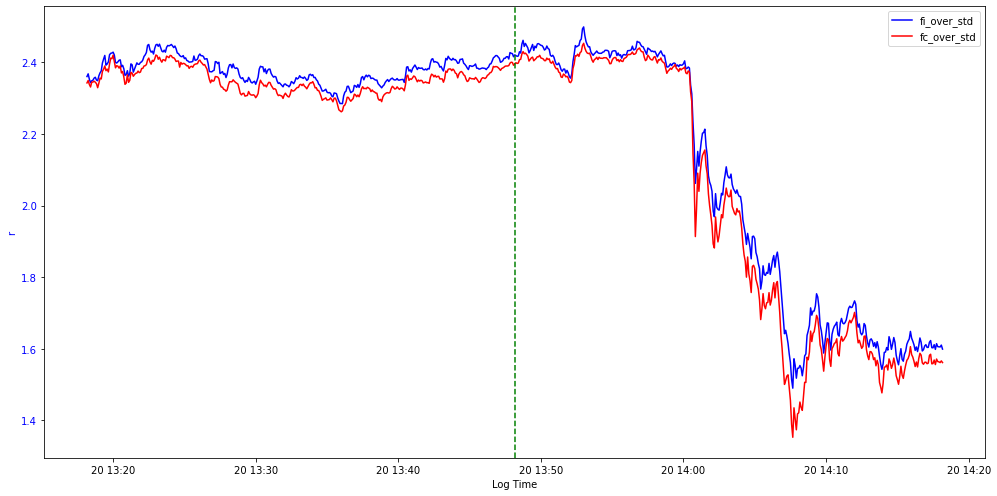

In [133]:
PythonUtil.plot_compare_mids(ww, 'fi_over_std', 'fc_over_std', selected_time='2024-09-20 13:48:09.999593')

contract:NSE_ABB


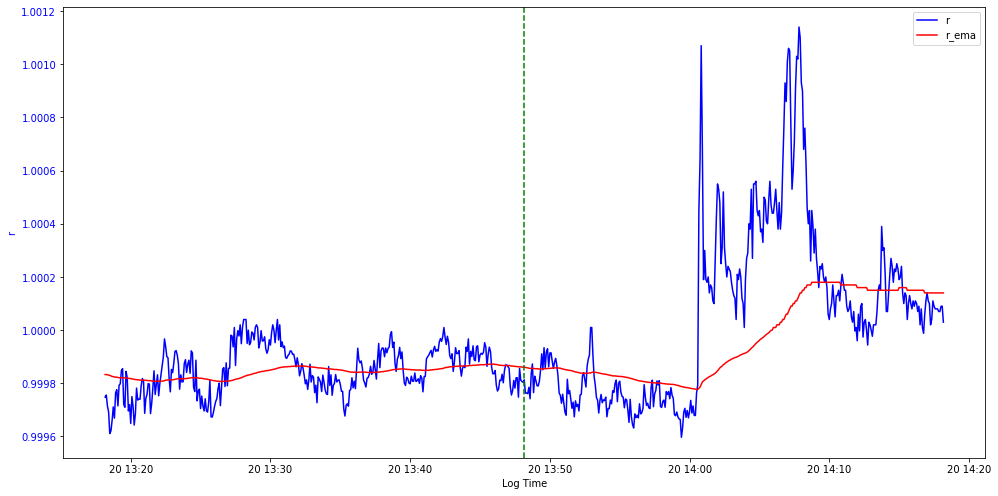

In [134]:
PythonUtil.plot_compare_mids(ww, 'r', 'r_ema', selected_time='2024-09-20 13:48:09.999593')

NSE_ABB


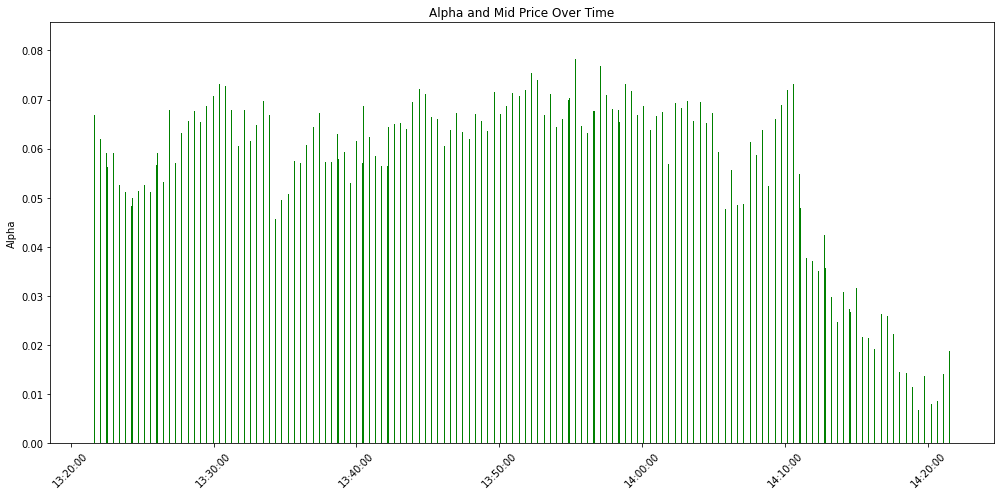

In [74]:
PythonUtil.plot_only_alpha(ww, 'norm_diff')

NSE_ABB


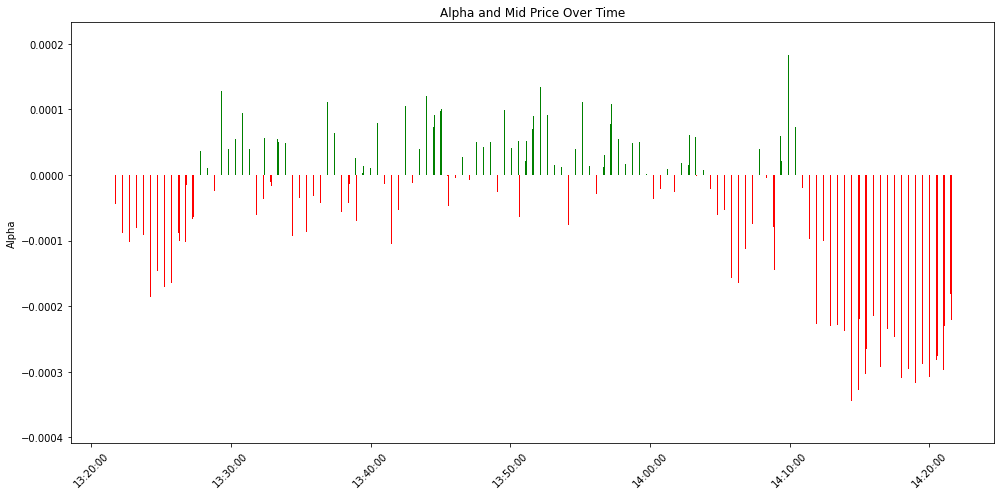

In [75]:
PythonUtil.plot_only_alpha(ww, 'ratio_diff')

contract:NSE_ABB


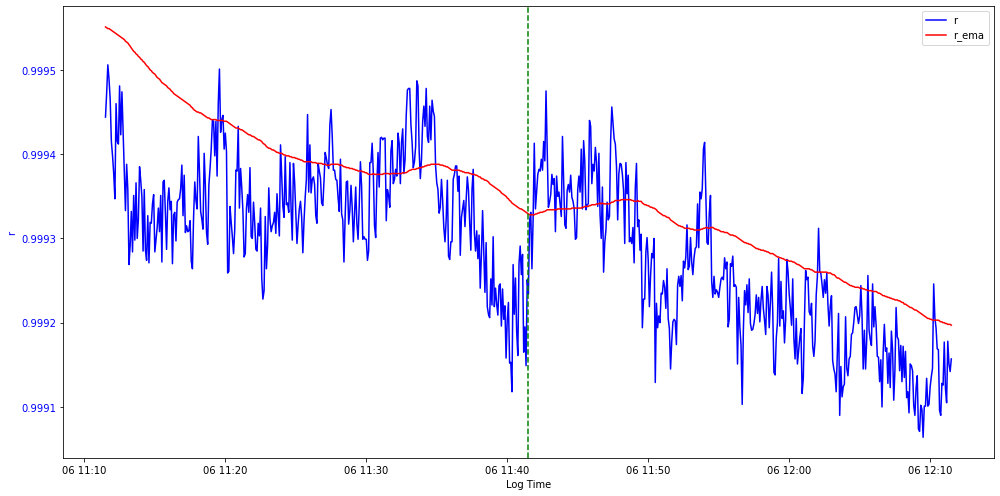

In [19]:
PythonUtil.plot_compare_mids(ww, 'r', 'r_ema', selected_time='2024-09-06 11:41:29.999155')

In [13]:
w

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,date_only,x,abs.x,z_score,abs.norm_diff,abs.abs.norm_diff,time_only
5537956,2024-09-06 11:41:29.999155969,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0076,0.0076,0.0407,0.0318,-0.0036,-0.0487,0.0156,-0.0036,0.4772,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5537957,2024-09-06 11:41:29.999155969,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0000,0.0001,0.0002,0.0002,0.0002,0.0396,0.0768,0.1043,0.2565,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5537958,2024-09-06 11:41:29.999155969,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0023,0.0342,-0.0866,-0.0524,-0.0752,-0.0912,-0.0410,-0.0570,0.6863,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5537959,2024-09-06 11:41:29.999155969,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0162,0.0081,0.0081,0.0404,0.0485,0.1131,0.2344,0.2182,0.3879,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5537960,2024-09-06 11:41:29.999155969,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0010,0.0021,0.0239,-0.0021,0.0260,0.0426,0.2057,0.2629,0.5839,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5538128,2024-09-06 11:41:29.999155969,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0000,0.0163,0.1058,0.1627,0.0936,0.1261,0.1058,0.0692,0.6915,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5538129,2024-09-06 11:41:29.999155969,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0380,0.0380,0.0598,0.0652,-0.0163,-0.0054,0.1957,0.3261,0.4185,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5538130,2024-09-06 11:41:29.999155969,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0000,0.0000,0.0423,0.0451,0.0479,-0.1114,-0.0451,-0.1001,0.0381,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155
5538131,2024-09-06 11:41:29.999155969,INFO,NSE_WIPRO,52435.0,0.318415,1,0.012925,0.011469,0.012813,2492730.0,2494640.0,0.999234,0.999329,0.999271,-0.000095,-0.000037,0.000205,0.000199,0.005132,0.96,0.0527,0.0527,0.0527,-0.0287,0.0048,0.1916,0.4264,0.7186,0.7617,-0.942681,-0.872391,-0.07029,1.080572,2024-09-06,-2.869583e-09,2.869583e-09,0.535492,0.07029,0.07029,11:41:29.999155


In [7]:
y3['abs.norm_diff'] = y3['norm_diff'].abs()
y3gt3 = get_zgt3_df(y3, 'abs.norm_diff')
PythonUtil.bucketcor(y3, 'abs.norm_diff', 'x', ['return.300000', 'return.600000', 'return.900000', 'return.1800000'])

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,group,return.300000,return.600000,return.900000,return.1800000
0,0.019433495941899803,-0.016171,-0.011593,-0.012694,0.001312
1,0.04079713956069275,-0.019070,0.000771,0.000178,-0.009431
2,0.06059326809223553,-0.005587,0.019232,0.021987,0.024452
3,0.07877435967097202,0.006014,0.026862,0.031821,0.031437
4,0.1770538250395453,0.016460,0.014129,0.031567,0.035404


In [27]:
y3['abs.norm_diff'] = y3['norm_diff'].abs()

y3gt3 = get_zgt3_df(y3, 'norm_diff')

PythonUtil.bucketcor(y3gt3, 'abs.norm_diff', 'x' , ['return.300000', 'return.600000', 'return.900000', 'return.1800000'])

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,group,return.300000,return.600000,return.900000,return.1800000
0,0.1548209935814206,-0.005878,0.020015,0.015153,-0.014615
1,0.1570938871628258,0.035667,0.018567,0.024668,-0.013093
2,0.15995193500313953,0.043028,0.015097,-0.018731,-0.002699
3,0.16343594846242182,0.009259,-0.037548,-0.073974,-0.075406
4,0.17349207516161497,-0.028742,-0.034398,-0.055148,-0.024570


In [103]:
# calculate_buckets(y3[(y3['fi_ret'] * y3['norm_diff'] > 0) & ((y3['vol_ratio_index'] / y3['vol_ratio_constituents']) > 1) & (y3['fi_ret'].abs() >= y3['fc_ret'].abs())], 'x')
calculate_buckets(y3[(y3['fi_ret'] * y3['norm_diff'] > 0)], 'x')

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total number of points:
5296896
Calculating bucketcor for alpha: x
                   group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0  6.594975243455198e-23     0.016224     0.017117      0.015116      0.006817      0.002853      -0.002283      -0.007509      -0.013293       -0.017364
1  9.364849280906778e-22     0.032923     0.032488      0.031676      0.019537      0.005520      -0.015870      -0.013616      -0.014927       -0.016667
2  7.268781735055052e-21     0.044579     0.053100      0.051586      0.029233      0.019520       0.003284      -0.001566       0.000024       -0.007397
3  6.687361250181549e-20     0.063860     0.066707      0.062414      0.038505      0.029796       0.005256       0.007964       0.006520        0.005254
4  9.137608380039504e-15     0.031390     0.023590      0.025469      0.015124      0.008191       0.010142       0.020591       0.028710        0.042129
Total num

In [117]:
calculate_buckets(f,'x', 5)

Total number of points:
5114409
Calculating bucketcor for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0   6.179655884280653e-23     0.016391     0.018504      0.016885      0.007484      0.003044      -0.002261      -0.004873      -0.010179       -0.012036
1   8.718721444424993e-22     0.032093     0.030668      0.029316      0.016292      0.006512      -0.019200      -0.016444      -0.016682       -0.019488
2  6.7106572544335094e-21     0.044313     0.052972      0.051292      0.032555      0.024126       0.009445       0.006203       0.006871       -0.002645
3    6.05117186348611e-20     0.063450     0.068223      0.065680      0.040016      0.032321       0.006947       0.005836       0.005443        0.005387
4   9.137608380039504e-15     0.028557     0.023744      0.024302      0.010244      0.006957       0.015007       0.023422       0.031543        0.042580
Tot

In [116]:
f = y3[(y3['fi_ret'] * y3['norm_diff'] > 0) ]
f = f[f['fi_over_std'].abs() < 2]
f = f[f['fc_over_std'].abs() < 2]
# f = f[f['norm_diff'].abs() > 0.06]

In [120]:
print(f['fi_over_std'].min())
print(f['fi_over_std'].max())

print(f['fc_over_std'].min())
print(f['fc_over_std'].max())

print(f['norm_diff'].min())
print(f['norm_diff'].max())
print(f['norm_diff'].mean())

f['z_norm_diff'] = zscore(f['norm_diff'])
f

-1.991076592189249
1.998962354945154
-1.9487351372041495
1.9920873950743443
-0.11997437303948502
0.17349207040814085
-0.0049389697133530724
-1.840001219551405


-1.991076592189249
1.998962354945154
-1.9487351372041495
1.9920873950743443
-0.11997437303948502
0.17349207040814085
-0.0049389697133530724


In [64]:
d = y3[(abs(y3['x']) > 1.2759630972231728e-09) & (abs(y3['x']) <= 1.4849974644130108e-09)]
d

,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,abs.norm_diff,date_only,abs.fi_ret,abs.fc_ret,x,abs.x,z_score
15045,2024-09-20 10:07:09.999593398,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.015191,0.007539,2545770.0,2544900.0,1.000340,1.000220,1.000160,0.000126,0.000185,0.000126,0.000173,0.003385,0.64,0.0023,0.0073,0.0321,0.0853,0.2598,0.1471,0.4876,0.7328,0.9232,1.170044,1.106288,0.063756,1.057631,0.063756,2024-09-20,0.000126,0.000173,1.390217e-09,1.390217e-09,4.029821
15046,2024-09-20 10:07:09.999593398,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.015191,0.007539,2545770.0,2544900.0,1.000340,1.000220,1.000160,0.000126,0.000185,0.000126,0.000173,0.003385,0.64,0.0000,0.0643,0.0593,0.0969,0.1215,0.1359,0.0754,0.1098,-0.1386,1.170044,1.106288,0.063756,1.057631,0.063756,2024-09-20,0.000126,0.000173,1.390217e-09,1.390217e-09,4.029821
15047,2024-09-20 10:07:09.999593398,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.015191,0.007539,2545770.0,2544900.0,1.000340,1.000220,1.000160,0.000126,0.000185,0.000126,0.000173,0.003385,0.64,0.0000,0.0000,0.1333,0.0961,0.3343,0.2207,0.2950,0.1114,-0.3453,1.170044,1.106288,0.063756,1.057631,0.063756,2024-09-20,0.000126,0.000173,1.390217e-09,1.390217e-09,4.029821
15048,2024-09-20 10:07:09.999593398,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.015191,0.007539,2545770.0,2544900.0,1.000340,1.000220,1.000160,0.000126,0.000185,0.000126,0.000173,0.003385,0.64,0.0000,0.0000,0.0605,0.1513,0.3632,0.0378,0.1059,0.1438,-0.2572,1.170044,1.106288,0.063756,1.057631,0.063756,2024-09-20,0.000126,0.000173,1.390217e-09,1.390217e-09,4.029821
15049,2024-09-20 10:07:09.999593398,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.015191,0.007539,2545770.0,2544900.0,1.000340,1.000220,1.000160,0.000126,0.000185,0.000126,0.000173,0.003385,0.64,0.0031,0.0021,0.0021,-0.0021,0.1439,0.0535,0.2283,0.1306,0.0699,1.170044,1.106288,0.063756,1.057631,0.063756,2024-09-20,0.000126,0.000173,1.390217e-09,1.390217e-09,4.029821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17540972,2024-09-10 10:24:39.999651524,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.026375,0.010815,2495030.0,2496790.0,0.999296,0.999243,0.999006,0.000053,0.000290,-0.000138,-0.000163,-0.003939,-0.84,0.0000,-0.0366,-0.0448,0.0285,0.0488,-0.2483,-0.0814,-0.1465,-0.1425,-0.851065,-0.787748,-0.063318,1.080378,0.063318,2024-09-10,0.000138,0.000163,-1.418523e-09,1.418523e-09,4.116023
17540973,2024-09-10 10:24:39.999651524,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.026375,0.010815,2495030.0,2496790.0,0.999296,0.999243,0.999006,0.000053,0.000290,-0.000138,-0.000163,-0.003939,-0.84,0.0000,-0.0284,-0.0511,0.0227,0.1136,-0.0341,0.2045,0.0170,0.2215,-0.851065,-0.787748,-0.063318,1.080378,0.063318,2024-09-10,0.000138,0.000163,-1.418523e-09,1.418523e-09,4.116023
17540974,2024-09-10 10:24:39.999651524,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.026375,0.010815,2495030.0,2496790.0,0.999296,0.999243,0.999006,0.000053,0.000290,-0.000138,-0.000163,-0.003939,-0.84,-0.0014,-0.0014,-0.0069,0.0041,0.0274,-0.3207,-0.1412,-0.3070,-0.1425,-0.851065,-0.787748,-0.063318,1.080378,0.063318,2024-09-10,0.000138,0.000163,-1.418523e-09,1.418523e-09,4.116023
17540975,2024-09-10 10:24:39.999651524,INFO,NSE_WIPRO,51677.5,0.318415,1,0.032986,0.026375,0.010815,2495030.0,2496790.0,0.999296,0.999243,0.999006,0.000053,0.000290,-0.000138,-0.000163,-0.003939,-0.84,0.0291,0.0194,0.0000,0.0194,0.1213,0.0146,-0.0146,-0.0097,0.0049,-0.851065,-0.787748,-0.063318,1.080378,0.063318,2024-09-10,0.000138,0.000163,-1.418523e-09,1.418523e-09,4.116023


In [65]:
w = getWorstDayTime(d, 'x','return.1800000')

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Day: 2024-09-20
Time: 10:07:09.999593
Rows diff than alpha: 47
Time: 10:07:59.999593
Rows diff than alpha: 66
Time: 10:22:04.999593
Rows diff than alpha: 98
Time: 14:02:34.999593
Rows diff than alpha: 93
Time: 14:06:29.999593
Rows diff than alpha: 62
Time: 14:08:49.999593
Rows diff than alpha: 38
Time: 14:22:54.999593
Rows diff than alpha: 123
Time: 14:25:44.999593
Rows diff than alpha: 93
Time: 14:30:39.999593
Rows diff than alpha: 44
Time: 14:31:34.999593
Rows diff than alpha: 27
Time: 14:32:34.999593
Rows diff than alpha: 77
Time: 15:20:44.999593
Rows diff than alpha: 76
Day: 2024-08-30
Time: 10:08:59.999906
Rows diff than alpha: 101
Time: 10:48:34.999906
Rows diff than alpha: 100
Time: 11:50:54.999906
Rows diff than alpha: 104
Day: 2024-09-11
Time: 10:15:49.999826
Rows diff than alpha: 48
Time: 11:36:29.999826
Rows diff than alpha: 76
Time: 12:09:04.999826
Rows diff than alpha: 95
Time: 14:42:39.999826
Rows diff than alpha: 90
Time: 15:16:44.999826
Rows diff than alpha: 59
Day: 202

In [66]:
w = w['worst_data']

In [84]:
# view all of the worst data with scroll
w


,log_time,log_level,contract,mid,weight,is_constituent,vol_ratio,vol_ratio_index,vol_ratio_constituents,fi,fc,r,r_ema,r_dema,ratio_diff,ratio_diff_dema,fi_ret,fc_ret,fc_ret_2,balance,return.1000,return.5000,return.10000,return.30000,return.60000,return.300000,return.600000,return.900000,return.1800000,fi_over_std,fc_over_std,norm_diff,r2,abs.norm_diff,date_only,abs.fi_ret,abs.fc_ret,x,abs.x,z_score,time_only
5550523,2024-09-06 11:47:24.999155969,INFO,NSE_ABB,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,-0.0003,-0.0172,-0.0212,0.0779,0.0451,0.1830,0.1091,0.3233,0.5571,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550524,2024-09-06 11:47:24.999155969,INFO,NSE_ABBOTINDIA,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,0.0000,0.0000,0.0000,0.0073,0.0375,0.0211,0.0145,0.0187,0.2584,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550525,2024-09-06 11:47:24.999155969,INFO,NSE_ABCAPITAL,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,0.0160,0.0183,0.0046,0.1119,0.0662,0.2055,0.1188,0.3814,0.9204,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550526,2024-09-06 11:47:24.999155969,INFO,NSE_ABFRL,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,0.0000,0.0000,0.0081,0.0081,0.0726,0.0968,0.0645,0.0807,0.3792,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550527,2024-09-06 11:47:24.999155969,INFO,NSE_ACC,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,-0.0052,0.0042,0.0031,0.0634,-0.0042,0.2971,0.2400,0.2805,0.6140,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5550695,2024-09-06 11:47:24.999155969,INFO,NSE_UPL,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,0.0041,-0.0122,-0.0122,0.0041,0.0244,0.0853,-0.0650,0.0488,0.6787,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550696,2024-09-06 11:47:24.999155969,INFO,NSE_VEDL,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,0.0000,-0.0163,-0.0163,0.0598,0.0598,0.2665,0.3862,0.3970,0.6037,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550697,2024-09-06 11:47:24.999155969,INFO,NSE_VOLTAS,0.0,0.000000,-1,0.000000,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,0.0000,-0.0014,-0.0028,0.0155,0.0155,0.0452,0.0169,0.3444,0.3853,-0.897271,-0.849163,-0.048108,1.056654,0.048108,2024-09-06,0.000168,0.000181,-1.465532e-09,1.465532e-09,4.259184,11:47:24.999155
5550698,2024-09-06 11:47:24.999155969,INFO,NSE_WIPRO,52557.5,0.318415,1,0.024475,0.007055,0.009496,2493870.0,2495230.0,0.999456,0.999343,0.999321,0.000113,0.000135,-0.000168,-0.000181,-0.005028,-0.96,-0.0048,0.0000,0.0096,0.0812,0.0717,0.3679,0.4014,0.5017,0.5829,-0.897271,-0.849163,-0.048108

In [72]:
ww = getTimeAround(w, non_expiry, 1800)

Time: 11:47:24.999155
Time before: 11:17:24
Time after: 12:17:24


/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: 'time_only'

In [92]:
y3gt3 = get_zgt3_df(f, 'x')
y3gt3 = get_df_with_groups(y3gt3, 'x')

/home/sameer.arora/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


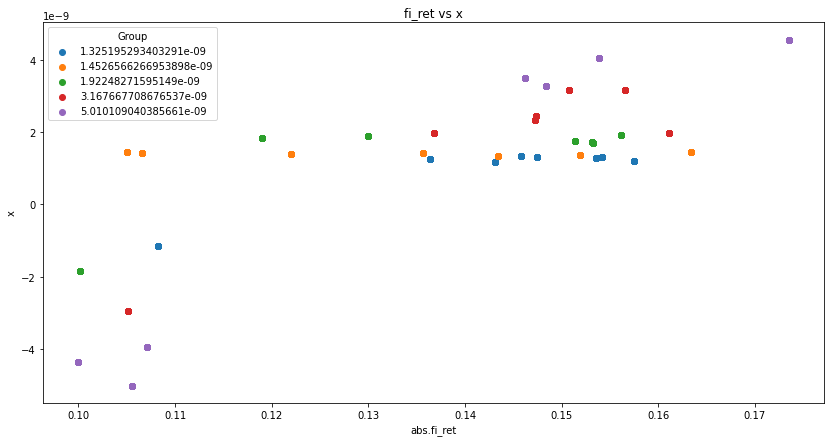

In [97]:
# plot ratio_diff vs x
fig, ax = plt.subplots(figsize=(14, 7))

mean_ratio_diff = y3gt3['norm_diff'].mean()
y3gt3['abs.fi_ret'] = y3gt3['fi_ret'].abs()
y3gt3['abs.fc_ret'] = y3gt3['fc_ret'].abs()
y3gt3['abs.norm_diff'] = y3gt3['norm_diff'].abs()

# Group the data by 'group'
groups = y3gt3.groupby('group')

# Iterate over each group and plot
for name, group in groups:
    ax.scatter(group['abs.norm_diff'], group['x'], label=name)

# ax.axvline(mean_ratio_diff, color='red', linestyle='--', linewidth=2, label='Mean norm_diff')

# Set labels and title
ax.set_xlabel('abs.fi_ret')
ax.set_ylabel('x')
ax.set_title('fi_ret vs x')

# Show legend
ax.legend(title='Group')

# Display the plot
plt.show()


In [ ]:
Calculating bucketcor for z-score > 3 for alpha: x
                    group  return.1000  return.5000  return.10000  return.30000  return.60000  return.300000  return.600000  return.900000  return.1800000
0  1.2759630972231728e-09     0.136389     0.153544      0.155088      0.114613      0.053794       0.087457       0.104011       0.087115        0.157741
1  1.4849974644130108e-09     0.206944     0.169045      0.134074      0.021942      0.023431       0.070438       0.158453       0.204162        0.121709
2   2.028509101078481e-09     0.239431     0.277615      0.289775      0.262531      0.203162       0.157134       0.261601       0.277349        0.243114
3   2.810570107243444e-09     0.219165     0.257263      0.176158      0.148806      0.148362       0.124582       0.270413       0.311819        0.291377
4  2.5001919805601957e-08     0.232830     0.158684      0.142975      0.131171      0.080323       0.090077       0.173937       0.258019        0.360668

In [1]:
y3_exp = expiry[(expiry['fi_ret'] * expiry['fc_ret'] > 0) & (expiry['fi_ret'] * expiry['norm_diff'] > 0)]

y3_exp['x'] = (
    y3_exp['norm_diff'] *
    y3_exp['fi_ret'].abs() *
    y3_exp['fc_ret'].abs() *
    np.exp(
        y3_exp['vol_ratio_index'] - y3_exp['vol_ratio_constituents']
    )
)

calculate_buckets(y3_exp, 'x')

NameError: name 'expiry' is not defined

In [8]:
y3 = non_expiry[(non_expiry['fi_ret'] * non_expiry['fc_ret'] > 0) & (non_expiry['fi_ret'] * non_expiry['norm_diff'] > 0)]

In [9]:
# linear regression
y3.columns


Index(['log_time', 'log_level', 'contract', 'mid', 'weight', 'is_constituent', 'vol_ratio', 'vol_ratio_index', 'vol_ratio_constituents', 'fi', 'fc', 'r', 'r_ema', 'r_dema', 'ratio_diff', 'ratio_diff_dema', 'fi_ret', 'fc_ret', 'fc_ret_2', 'balance', 'return.1000', 'return.5000', 'return.10000', 'return.30000', 'return.60000', 'return.300000', 'return.600000', 'return.900000', 'return.1800000', 'fi_over_std', 'fc_over_std', 'norm_diff', 'r2', 'abs.norm_diff', 'date_only'], dtype='object')

In [13]:
from sklearn.linear_model import LinearRegression
def find_best_feature(signals_to_select_from, signals_selected, df, label):
    best_feature = None
    best_correlation = -np.inf
    y = df[label]
    for feature in signals_to_select_from:
        X = df[signals_selected + [feature]]
        model = LinearRegression().fit(X, y)
        combined_signal = np.dot(X, model.coef_)
        correlation = np.corrcoef(combined_signal, y)[0, 1]
        if correlation > best_correlation:
            best_correlation = correlation
            best_feature = feature
    
    print("best_feature:", best_feature)
    print("best_correlation:", best_correlation)
    return best_feature, best_correlation

def select_top_features(df, features, label_col, top_n=10):
    signals_selected = []
    signals_to_select_from = features.copy()
    while len(signals_selected) < top_n and signals_to_select_from:
        print(len(signals_selected), end=' ')
        best_feature, _ = find_best_feature(signals_to_select_from, signals_selected, df, label_col)
        print("signals selected:", signals_selected)
        if best_feature:
            signals_selected.append(best_feature)
            signals_to_select_from.remove(best_feature)

In [15]:
select_top_features(y3, ['vol_ratio', 'vol_ratio_index', 'vol_ratio_constituents', 'fi', 'balance', 'fc', 'r', 'r_ema', 'r_dema', 'ratio_diff', 'ratio_diff_dema', 'fi_ret', 'fc_ret', 'fc_ret_2', 'norm_diff'], 'return.1800000')

0 best_feature: ratio_diff
best_correlation: 0.030115732062681
signals selected: []
1 best_feature: fc_ret
best_correlation: 0.0407074464509354
signals selected: ['ratio_diff']
2 best_feature: fi
best_correlation: 0.05055141007236373
signals selected: ['ratio_diff', 'fc_ret']
3 best_feature: balance
best_correlation: 0.05195409803670649
signals selected: ['ratio_diff', 'fc_ret', 'fi']
4 best_feature: vol_ratio_constituents
best_correlation: 0.05282704687523744
signals selected: ['ratio_diff', 'fc_ret', 'fi', 'balance']
5 best_feature: vol_ratio
best_correlation: 0.05331525143802855
signals selected: ['ratio_diff', 'fc_ret', 'fi', 'balance', 'vol_ratio_constituents']
6 best_feature: vol_ratio_index
best_correlation: 0.053636650015143825
signals selected: ['ratio_diff', 'fc_ret', 'fi', 'balance', 'vol_ratio_constituents', 'vol_ratio']
7 best_feature: fc_ret_2
best_correlation: 0.0538767334106805
signals selected: ['ratio_diff', 'fc_ret', 'fi', 'balance', 'vol_ratio_constituents', 'vol_ra